# PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment = 'local'  # work environment ('kaggle', 'colab', 'local')
    device      = 'GPU'    # device ('CPU', 'GPU', 'TPU')
    num_workers = 4        # no. cores

    # general
    version  = 120    # notebook version (for saving outputs)
    debug    = False  # debug mode runs 5 batches for 2 epochs 
    training = True   # if False, only inference is run
    tracking = True   # track results using neptune.ai
    seed     = 13353  # random state

    # data
    num_folds  = 5      # number of CV folds
    data_2019  = True   # append 2019 labeled data to training folds (1a)
    data_pl    = 0.2    # False or percentage of appended pseudo-labeled data (1b)
    data_ext   = False  # False or list with external dataset ids (2, 3, 4, 5)
    drop_dupl  = True   # drop duplicate images from training folds
    drop_outs  = False  # drop outliers from training folds
    oversample = False  # enable oversampling through WeightedRandomSampler()
    
    # label noise
    drop_noise = False  # False or percentage of removed noisy labels in training folds
    flip_noise  = False  # False or percentage of flipped noisy labels in training folds

    # image size and augmentations 
    image_size = 512                # image size after random crop
    crop_scale = (0.10, 1)          # min scale, max scale
    gr_shuffle   = (3, 3)             # number of tiles in shuffled grid
    ssr        = [0.05, 0.05, 360]  # shift, scale, rotation limits
    huesat     = [20, 20, 20]       # hue, saturation, value limits
    bricon     = [0.1, 0.1]         # brightness, contrast limits
    blur_limit = 3                  # blur limit
    dist_limit = 0.1                # distortion limit
    cutout     = [5, 0.1]           # number of squares, size of squares
    p_augment  = 0.5                # prob. of augmentations except for flips
    cutmix     = [0, 1]             # cutmix batch-level probability, alpha
    normalize  = False              # pixel normalization (False, 'dataset', 'imagenet')

    # model architecture
    backbone = 'swsl_resnext50_32x4d'  # convolutional backbone
    weights  = 'custom'                # weights ('empty', 'imagenet', 'custom')
    save_all = False                   # save weights from each epoch

    # pretrained model
    pr_version     = 3   # notebook version (2, 3, 4, 5)
    pr_num_classes = 10  # no. classes (2: 4, 3: 10, 4: 2, 5: 17)

    # training
    batch_size  = 32    # no. images per batch
    num_epochs  = 10    # no. epochs per fold
    fine_tune    = 2     # fine-tuning dense layers (False or no. epochs)
    accum_iter  = 1     # no. batches for gradient accumalation
    use_amp     = True  # automated mixed precision mode

    # learning rate and optimizer
    eta     = 1e-4    # starting learning rate
    eta_min = 1e-6    # ending learning rate
    optim   = 'AdamP'  # LR optimizer ('Adam', 'AdamW', 'AdamP')
    decay   = 0       # weight decay of optimizer (L2 regularization)

    # learning rate scheduler
    warmup          = 1                  # no. epochs for warmup
    schedule        = 'CosineAnnealing'  # LR scheduler after warmup
    update_on_batch = True               # update LR after every batch or epoch

    # loss function
    loss_fn     = 'CE'         # loss function ('CE', 'OHEM', 'SCE', 'CCE', 'Focal', 'FocalCosine', 'Taylor', 'BiTempered')
    smoothing   = 0.2          # label smoothing (works with all losses)
    ohem        = 0.8          # OHEM loss parameters: top-k percentage
    sce         = [0.1, 1.0]   # SCE loss parameters: alpha, beta
    cce         = 5            # CCE loss parameters: gamma
    focal       = [1, 2]       # Focal loss parameters: alpha, gamma
    focalcosine = [1, 2, 0.1]  # FocalCosine loss parameters: alpha, gamma, xent
    taylor      = 2            # Taylor loss parameters: n
    bitempered  = [0.3, 1.0]   # BiTempered loss parameters: t1, t2

    # epoch-based changes
    step_size  = False  # False or list with image_size multiplier for each epoch
    step_class = False  # False or list with num_classes for each epoch (2 or 5)
    step_p_aug = False  # False or list with p_augment multiplier for each epoch
    step_loss  = False  # False or list with loss functions for each epoch

    # inference
    num_tta = 1  # no. TTA flips (between 1 and 8)

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

# PREPARATIONS

In [3]:
####### ENVIRONMENT SETUP

##### COLAB

import os
if (CFG['environment'] == 'colab') and (not os.path.exists('/content/cassava/')):

    # mount drive
    from google.colab import drive
    drive.mount('/content/drive')  

    # set up Kaggle API
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    !mkdir -p ~/.kaggle
    !cp '/content/drive/MyDrive/Competitions/kaggle.json' ~/.kaggle/
    !ls ~/.kaggle

    # download data
    !mkdir '/content/cassava/'
    !kaggle kernels output kozodoi/merge-and-zip-2019-2020-data -p '/content/cassava/'
    !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/'
    !rm -rf '/content/cassava/images.zip'
    
    
##### KAGGLE

if (CFG['environment'] == 'kaggle') and (not os.path.exists('cassava/')):

    # extract data
    !mkdir 'cassava/'
    !unzip -o -q '/kaggle/input/merge-and-zip-2019-2020-data/images.zip' -d 'cassava/'
    !cp '/kaggle/input/merge-and-zip-2019-2020-data/train.csv' 'cassava/'

In [4]:
####### WORKING PATHS

# kaggle
if CFG['environment'] == 'kaggle':
    CFG['data_path']  = 'cassava/'
    CFG['model_path'] = ''
    CFG['out_path']   = ''

# colab
if CFG['environment'] == 'colab':
    CFG['data_path']  = '/content/cassava/'
    CFG['model_path'] = '/content/drive/MyDrive/Cassava/pretraining/v' + str(CFG['pr_version']) + '/'
    CFG['out_path']   = '/content/drive/MyDrive/Cassava/training/v'    + str(CFG['version'])    + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])

# local
if CFG['environment'] == 'local':
    CFG['data_path']  = '../data/'
    CFG['model_path'] = '../pretraining/v' + str(CFG['pr_version']) + '/'
    CFG['out_path']   = '../training/v'    + str(CFG['version'])    + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])

In [5]:
####### PACKAGES FOR TPU

if CFG['device'] == 'TPU':
        
    # install XLA
    xla_version = 'nightly' # (1.7, 'nightly')
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version $xla_version

    # settings
    if CFG['environment'] == 'colab':
        import os
        assert os.environ['COLAB_TPU_ADDR']
    os.environ['XLA_USE_BF_16'] = '1'
    os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'

    # imports
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.distributed.parallel_loader as pl

In [6]:
####### PACKAGES

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler, WeightedRandomSampler
from torch.utils.data.distributed import DistributedSampler
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.autograd import Function

!pip install timm
import timm
from timm.utils import *

from contextlib import suppress

!pip install --upgrade -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

!pip install git+'https://github.com/ildoonet/pytorch-gradual-warmup-lr.git'
from warmup_scheduler import GradualWarmupScheduler  

!pip install adamp
from adamp import AdamP

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.special import softmax

from tqdm import tqdm

import random
import math
import time
import sys
import os
import pickle

import gc

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-huqqtrh8


In [7]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    
    # install neptune
    !pip install neptune-client
    import neptune 

    # create exoeriment
    neptune.init(api_token = 'eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiZjQ1ZTgwOTYtZjcwNy00MjkyLTg0ZTQtZDBmMzk5MGNjOTE1In0=',
                 project_qualified_name = 'kozodoi/cassava')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://ui.neptune.ai/kozodoi/cassava/e/CAS-123


In [8]:
####### TRAINING DEVICE

if CFG['device'] == 'TPU':
    print('Training on TPU...')
    device = torch.device('cpu')
    
if CFG['device'] == 'GPU':
    print('Training on GPU...')
    if CFG['environment'] == 'local':
        device = torch.device('cuda:1')
    else:
        device = torch.device('cuda:0')

if CFG['device'] == 'CPU':
    print('Training on CPU...')
    device = torch.device('cpu') 

Training on GPU...


In [9]:
####### UTILITIES

##### RANDOM FOR LOOPS

def randomly(seq):
    shuffled = list(seq)
    random.shuffle(shuffled)
    return iter(shuffled)


##### DEVICE-AWARE PRINTING 

def smart_print(expression, CFG):
    if CFG['device'] != 'TPU':
        print(expression)
    else:
        xm.master_print(expression)


##### DEVICE-AWARE SAVING

def smart_save(weights, path, CFG):
    if CFG['device'] != 'TPU':
        torch.save(weights, path)    
    else:
        xm.save(weights, path) 

    
##### RANDOMNESS

def seed_everything(seed, CFG):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    smart_print('Setting random seed to {}...'.format(seed), CFG)
    
seed_everything(CFG['seed'], CFG)

Setting random seed to 13353...


# DATA PREP

In [10]:
####### 2020 COMPETITION DATA

# import data
df = pd.read_csv(CFG['data_path'] + 'train.csv')
df = df.loc[df['source'] == 2020].reset_index(drop = True)
    
# num classes
CFG['num_classes'] = df['label'].nunique()

# partitioning
df['fold'] = -1
skf = StratifiedKFold(n_splits = CFG['num_folds'], random_state = CFG['seed'], shuffle = True)
for fold, (trn_idx, val_idx) in enumerate(skf.split(df, df['label'])):
    df.loc[val_idx, 'fold'] = fold
    
# check folds
pd.crosstab(df['fold'], df['label'])

label    0    1    2     3    4
fold                           
0      218  438  477  2631  516
1      218  438  477  2631  516
2      217  438  477  2632  515
3      217  438  477  2632  515
4      217  437  478  2632  515

In [11]:
####### 2019 COMPETITION DATA

##### LABELED DATA

if CFG['data_2019']:

    # import data
    df_2019 = pd.read_csv(CFG['data_path'] + 'train.csv')
    df_2019 = df_2019.loc[df_2019['source'] == 2019].reset_index(drop = True)
    df_2019['fold'] = -1
        
    # check classes
    display(df_2019['label'].value_counts())


##### PSEUDO-LABELED DATA

if CFG['data_pl']:

    # import
    if CFG['environment'] == 'colab':
        !kaggle kernels output kozodoi/pseudo-labeling-v57 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/unlabeled_images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/unlabeled_images.zip'
    df_pl = pd.read_csv(CFG['data_path'] + 'df_pl.csv')
    df_pl['fold'] = -1

    # filter confident predictions
    df_pl['confidence'] = df_pl.filter(like = 'c').max(axis = 1)
    df_pl = df_pl.sort_values('confidence', ascending = False)
    df_pl = df_pl.head(int(CFG['data_pl'] * len(df_pl)))
    df_pl = df_pl[['image_id', 'label', 'fold']]

    # check classes
    display(df_pl['label'].value_counts())

3    2658
1    1443
2     773
0     466
4     316
Name: label, dtype: int64

3    2355
1     412
4     260
2     196
0      50
Name: label, dtype: int64

In [12]:
####### EXTERNAL DATA [HEALTHY]

if CFG['data_ext']:

    # placeholder
    df_ext = pd.DataFrame(columns = ['image_id', 'label', 'source'])


    ##### DATASET 2

    if 2 in CFG['data_ext']:

        # import images
        !kaggle kernels output kozodoi/prepare-dataset-2 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_2 = pd.read_csv(CFG['data_path'] + 'df_2.csv')
        df_2 = df_2.loc[df_2['label'] == 4].reset_index(drop = True)
        df_2['source'] = 2
        df_ext = pd.concat([df_ext, df_2], axis = 0).reset_index(drop = True)
        

    ##### DATASET 3

    if 3 in CFG['data_ext']:

        # import
        !kaggle kernels output kozodoi/prepare-dataset-3 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_3 = pd.read_csv(CFG['data_path'] + 'df_3.csv')
        df_3 = df_3.loc[df_3['label'] == 4].reset_index(drop = True)
        df_3['source'] = 3
        df_ext = pd.concat([df_ext, df_3], axis = 0).reset_index(drop = True)


    ##### DATASET 4

    if 4 in CFG['data_ext']:

        # import
        !kaggle kernels output kozodoi/prepare-dataset-4 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_4 = pd.read_csv(CFG['data_path'] + 'df_4.csv')
        df_4 = df_4.loc[df_4['label'] == 4].reset_index(drop = True)
        df_4['source'] = 4
        df_ext = pd.concat([df_ext, df_4], axis = 0).reset_index(drop = True)


    ##### DATASET 5

    if 5 in CFG['data_ext']:

        # import
        !kaggle kernels output kozodoi/prepare-dataset-5 -p '/content/cassava/'
        !unzip -o -q '/content/cassava/images.zip' -d '/content/cassava/train_images/'
        !rm -rf '/content/cassava/images.zip'

        # filtering
        df_5 = pd.read_csv(CFG['data_path'] + 'df_5.csv')
        df_5 = df_5.loc[df_5['label'] == 4].reset_index(drop = True)
        df_5['source'] = 5
        df_ext = pd.concat([df_ext, df_5], axis = 0).reset_index(drop = True)


    ##### PARTITIONING

    df_ext['source'] = df_ext['source'].astype('int')
    df_ext['fold']   = -1
    display(df_ext['source'].value_counts())

In [13]:
####### IDENTIFY BAD EXAMPLES

##### DUPLICATES

if CFG['drop_dupl']:

    # duplicates: 2019 vs 2020 (hash)
    #duplicates = [('1002088496.jpg', 'train-cbsd-614.jpg'), ('1024367055.jpg', 'train-cgm-677.jpg'), ('1046486747.jpg', 'train-cbsd-1272.jpg'), ('1050134400.jpg', 'train-cmd-1049.jpg'), ('1059986462.jpg', 'train-cgm-416.jpg'), ('1069816211.jpg', 'train-cgm-456.jpg'), ('1072259548.jpg', 'train-cbsd-355.jpg'), ('1080179563.jpg', 'train-cmd-10.jpg'), ('1080281713.jpg', 'train-cmd-1009.jpg'), ('1081937072.jpg', 'train-cmd-809.jpg'), ('1089661926.jpg', 'train-cbsd-1248.jpg'), ('1099882902.jpg', 'train-cbsd-50.jpg'), ('1102683272.jpg', 'train-cmd-2099.jpg'), ('1118493919.jpg', 'train-cmd-1643.jpg'), ('112557905.jpg', 'train-cmd-207.jpg'), ('1128747807.jpg', 'train-cmd-2601.jpg'), ('1133309905.jpg', 'train-cgm-714.jpg'), ('114251805.jpg', 'train-cgm-482.jpg'), ('1143548479.jpg', 'train-cmd-1456.jpg'), ('1144657211.jpg', 'train-cmd-646.jpg'), ('11690064.jpg', 'train-cbb-345.jpg'), ('1172621803.jpg', 'train-cmd-2371.jpg'), ('1180559828.jpg', 'train-cmd-986.jpg'), ('1194116552.jpg', 'train-cmd-2630.jpg'), ('1197262681.jpg', 'train-cmd-2222.jpg'), ('1199797130.jpg', 'train-cgm-303.jpg'), ('1209827516.jpg', 'train-cgm-438.jpg'), ('1215008377.jpg', 'train-cmd-42.jpg'), ('1227903119.jpg', 'train-cmd-528.jpg'), ('1234931385.jpg', 'train-cgm-515.jpg'), ('1239998285.jpg', 'train-cbsd-1213.jpg'), ('1242546458.jpg', 'train-cmd-411.jpg'), ('125037460.jpg', 'train-cmd-363.jpg'), ('1252538311.jpg', 'train-cmd-1558.jpg'), ('1261540961.jpg', 'train-cmd-1698.jpg'), ('1264219928.jpg', 'train-cgm-426.jpg'), ('1275608644.jpg', 'train-cmd-1278.jpg'), ('1276802461.jpg', 'train-cbb-261.jpg'), ('1277936443.jpg', 'train-cmd-1970.jpg'), ('1285287595.jpg', 'train-cbsd-293.jpg'), ('1285588852.jpg', 'train-cbsd-446.jpg'), ('128820265.jpg', 'train-cmd-2535.jpg'), ('1290734565.jpg', 'train-cmd-2507.jpg'), ('1302078468.jpg', 'train-cbsd-1203.jpg'), ('1303876802.jpg', 'train-cbb-429.jpg'), ('1324257289.jpg', 'train-cmd-2124.jpg'), ('1335452154.jpg', 'train-cmd-2260.jpg'), ('1335531094.jpg', 'train-cbsd-1390.jpg'), ('1339257499.jpg', 'train-cbb-18.jpg'), ('1348941923.jpg', 'train-cmd-1194.jpg'), ('1359438859.jpg', 'train-cbb-448.jpg'), ('1362645481.jpg', 'train-cmd-2602.jpg'), ('1368162685.jpg', 'train-cgm-213.jpg'), ('1381222280.jpg', 'train-cmd-2481.jpg'), ('1385160350.jpg', 'train-cmd-2316.jpg'), ('1386157120.jpg', 'train-cmd-1724.jpg'), ('1387354222.jpg', 'train-cmd-279.jpg'), ('13975743.jpg', 'train-cgm-291.jpg'), ('1415940915.jpg', 'train-cmd-1659.jpg'), ('1418463220.jpg', 'train-cgm-405.jpg'), ('1424930187.jpg', 'train-cmd-1454.jpg'), ('1432249645.jpg', 'train-cbsd-157.jpg'), ('1438970432.jpg', 'train-cmd-489.jpg'), ('1442451975.jpg', 'train-cmd-1806.jpg'), ('1443356256.jpg', 'train-cgm-109.jpg'), ('144873912.jpg', 'train-cmd-500.jpg'), ('1451862945.jpg', 'train-cmd-100.jpg'), ('1454074626.jpg', 'train-cmd-200.jpg'), ('1455906876.jpg', 'train-cbsd-1056.jpg'), ('145911417.jpg', 'train-cmd-625.jpg'), ('1460538853.jpg', 'train-cmd-839.jpg'), ('1467601507.jpg', 'train-cmd-893.jpg'), ('1472183727.jpg', 'train-cmd-1460.jpg'), ('1476112995.jpg', 'train-cbsd-227.jpg'), ('1478375260.jpg', 'train-cmd-137.jpg'), ('1479168350.jpg', 'train-cmd-1189.jpg'), ('1483777554.jpg', 'train-cmd-1235.jpg'), ('1492079032.jpg', 'train-cbsd-729.jpg'), ('15177566.jpg', 'train-cmd-374.jpg'), ('1531006450.jpg', 'train-cmd-1513.jpg'), ('1561961236.jpg', 'train-cgm-670.jpg'), ('1562043567.jpg', '3551135685.jpg'), ('1571832603.jpg', 'train-cbsd-1185.jpg'), ('1575013487.jpg', 'train-cmd-2016.jpg'), ('1575866220.jpg', 'train-cbsd-39.jpg'), ('1578897742.jpg', 'train-cmd-273.jpg'), ('1578977008.jpg', 'train-cmd-960.jpg'), ('1587009529.jpg', 'train-cmd-1264.jpg'), ('1595577438.jpg', 'train-cgm-125.jpg'), ('1595866872.jpg', 'train-cbsd-34.jpg'), ('1598187662.jpg', 'train-cmd-1332.jpg'), ('1612059624.jpg', 'train-cgm-111.jpg'), ('1612177465.jpg', 'train-cgm-432.jpg'), ('1622568975.jpg', 'train-cbsd-691.jpg'), ('162460466.jpg', 'train-cmd-1748.jpg'), ('162740748.jpg', 'train-cbsd-479.jpg'), ('1635358503.jpg', 'train-cmd-1551.jpg'), ('164781857.jpg', 'train-cmd-804.jpg'), ('1648944957.jpg', 'train-cmd-1978.jpg'), ('1650399375.jpg', 'train-cmd-1841.jpg'), ('1652157522.jpg', 'train-cbsd-137.jpg'), ('1657763940.jpg', 'train-cmd-74.jpg'), ('1666313319.jpg', 'train-cmd-996.jpg'), ('1667719250.jpg', 'train-cmd-1471.jpg'), ('1675424931.jpg', 'train-cgm-592.jpg'), ('1675758805.jpg', 'train-cmd-2358.jpg'), ('1681477511.jpg', 'train-cmd-2583.jpg'), ('1700921498.jpg', 'train-cmd-656.jpg'), ('1706377266.jpg', 'train-cbsd-671.jpg'), ('170814157.jpg', 'train-cgm-167.jpg'), ('1713444587.jpg', 'train-cgm-757.jpg'), ('171546937.jpg', 'train-cbb-193.jpg'), ('1722033032.jpg', 'train-cbb-410.jpg'), ('1724843600.jpg', 'train-cbsd-1034.jpg'), ('1726864717.jpg', 'train-cmd-298.jpg'), ('1727205281.jpg', 'train-cbsd-1016.jpg'), ('1732173388.jpg', 'train-cgm-247.jpg'), ('173849826.jpg', 'train-cgm-404.jpg'), ('1738923752.jpg', 'train-cbsd-321.jpg'), ('1747122718.jpg', 'train-cbsd-795.jpg'), ('1759147122.jpg', 'train-cmd-967.jpg'), ('177187875.jpg', 'train-cmd-1400.jpg'), ('1775105594.jpg', 'train-cmd-2191.jpg'), ('1786164172.jpg', 'train-cgm-542.jpg'), ('178880482.jpg', 'train-cmd-1067.jpg'), ('1789470358.jpg', 'train-cgm-345.jpg'), ('1792425947.jpg', 'train-cgm-764.jpg'), ('179693098.jpg', 'train-cbsd-907.jpg'), ('1814144394.jpg', 'train-cbsd-48.jpg'), ('1815147513.jpg', 'train-cbb-143.jpg'), ('1817648564.jpg', 'train-cmd-1225.jpg'), ('1818510196.jpg', 'train-cbsd-1220.jpg'), ('181857749.jpg', 'train-cgm-680.jpg'), ('1822682006.jpg', 'train-cmd-524.jpg'), ('182701414.jpg', 'train-cbsd-922.jpg'), ('1829924843.jpg', 'train-cgm-84.jpg'), ('1830481275.jpg', 'train-cbb-335.jpg'), ('183535060.jpg', 'train-cmd-1529.jpg'), ('1836918462.jpg', 'train-cbsd-1210.jpg'), ('1845811420.jpg', 'train-cgm-599.jpg'), ('1846052077.jpg', 'train-cmd-1465.jpg'), ('1859265664.jpg', 'train-cmd-1534.jpg'), ('1865586599.jpg', 'train-cbsd-112.jpg'), ('1867590389.jpg', 'train-cgm-196.jpg'), ('1875533805.jpg', 'train-cbsd-1028.jpg'), ('1876922129.jpg', 'train-cbb-365.jpg'), ('1886905036.jpg', 'train-cbb-303.jpg'), ('1889215655.jpg', 'train-cbb-299.jpg'), ('1890187078.jpg', 'train-cbsd-943.jpg'), ('189339781.jpg', 'train-cmd-2112.jpg'), ('1897585920.jpg', 'train-cmd-2420.jpg'), ('190449795.jpg', 'train-cbsd-47.jpg'), ('1907786974.jpg', 'train-cbb-272.jpg'), ('1909170813.jpg', 'train-cmd-1056.jpg'), ('1909629301.jpg', 'train-cbsd-1322.jpg'), ('1923898414.jpg', 'train-cbb-334.jpg'), ('1924122147.jpg', 'train-cmd-1580.jpg'), ('193330948.jpg', 'train-cbsd-1110.jpg'), ('1937240444.jpg', 'train-cgm-522.jpg'), ('1941569739.jpg', 'train-cbsd-593.jpg'), ('1948579246.jpg', 'train-cmd-590.jpg'), ('1958784721.jpg', 'train-cmd-955.jpg'), ('1960632681.jpg', 'train-cbsd-29.jpg'), ('1961893968.jpg', 'train-cgm-690.jpg'), ('1968165864.jpg', 'train-cmd-581.jpg'), ('1969270538.jpg', 'train-cgm-686.jpg'), ('1972732995.jpg', 'train-cmd-1675.jpg'), ('197432034.jpg', 'train-cgm-108.jpg'), ('1978570472.jpg', 'train-cmd-2638.jpg'), ('1981291103.jpg', 'train-cgm-726.jpg'), ('1983266061.jpg', 'train-cmd-1714.jpg'), ('1983607439.jpg', 'train-cmd-1048.jpg'), ('1993434265.jpg', 'train-cmd-2634.jpg'), ('1993626674.jpg', 'train-cmd-1747.jpg'), ('1995608609.jpg', 'train-cgm-115.jpg'), ('1998802568.jpg', 'train-cmd-1395.jpg'), ('2005545104.jpg', 'train-cbb-83.jpg'), ('2011856234.jpg', 'train-cmd-2057.jpg'), ('2012411582.jpg', 'train-cbsd-1391.jpg'), ('2016929365.jpg', 'train-cmd-1261.jpg'), ('2021239499.jpg', 'train-cgm-623.jpg'), ('2025224084.jpg', 'train-cmd-1231.jpg'), ('203075136.jpg', 'train-cgm-671.jpg'), ('20361463.jpg', 'train-cbsd-1032.jpg'), ('20518383.jpg', 'train-cgm-742.jpg'), ('2058684347.jpg', 'train-cgm-463.jpg'), ('2059449835.jpg', 'train-cmd-1543.jpg'), ('2066754199.jpg', 'train-cbsd-755.jpg'), ('2069885945.jpg', 'train-cbsd-921.jpg'), ('2084909272.jpg', 'train-cmd-1442.jpg'), ('2105589928.jpg', 'train-cgm-189.jpg'), ('2109494038.jpg', 'train-cmd-712.jpg'), ('2110727627.jpg', 'train-cgm-625.jpg'), ('2115508050.jpg', 'train-cmd-2262.jpg'), ('2129562481.jpg', 'train-cmd-1008.jpg'), ('2133889430.jpg', 'train-cmd-1327.jpg'), ('2139342889.jpg', 'train-cgm-314.jpg'), ('2148757008.jpg', 'train-cbsd-1285.jpg'), ('2149970580.jpg', 'train-cbb-73.jpg'), ('2161608186.jpg', 'train-cmd-1834.jpg'), ('2164751945.jpg', 'train-cmd-1259.jpg'), ('2173229407.jpg', 'train-cgm-697.jpg'), ('2177675284.jpg', 'train-cbb-361.jpg'), ('2184718270.jpg', 'train-cgm-664.jpg'), ('2186683331.jpg', 'train-cmd-686.jpg'), ('2203204324.jpg', 'train-cbb-386.jpg'), ('220707732.jpg', 'train-cgm-673.jpg'), ('2207440318.jpg', 'train-cmd-1136.jpg'), ('2208909764.jpg', 'train-cmd-2505.jpg'), ('2216899710.jpg', 'train-cmd-2482.jpg'), ('2221731773.jpg', 'train-cmd-128.jpg'), ('2221889127.jpg', 'train-cbb-19.jpg'), ('2231704125.jpg', 'train-cgm-688.jpg'), ('2232959596.jpg', 'train-cmd-2652.jpg'), ('2241394681.jpg', 'train-cgm-343.jpg'), ('2252529694.jpg', '911861181.jpg'), ('2252678193.jpg', 'train-cgm-410.jpg'), ('2260330058.jpg', 'train-cmd-112.jpg'), ('2260521441.jpg', 'train-cgm-157.jpg'), ('2264163141.jpg', 'train-cbb-355.jpg'), ('2265725202.jpg', 'train-cmd-1315.jpg'), ('226962956.jpg', 'train-cbsd-623.jpg'), ('227401382.jpg', 'train-cmd-353.jpg'), ('2308142554.jpg', 'train-cmd-782.jpg'), ('2314598518.jpg', 'train-cmd-2046.jpg'), ('2316499026.jpg', 'train-cmd-577.jpg'), ('2317623527.jpg', 'train-cmd-1853.jpg'), ('2318645335.jpg', 'train-cbb-136.jpg'), ('2328599167.jpg', 'train-cmd-1084.jpg'), ('2329316953.jpg', 'train-cmd-1229.jpg'), ('2330851012.jpg', 'train-cbsd-754.jpg'), ('2331038619.jpg', 'train-cmd-1282.jpg'), ('2332024831.jpg', 'train-cbsd-1395.jpg'), ('2338213285.jpg', 'train-cgm-543.jpg'), ('2339596137.jpg', 'train-cmd-275.jpg'), ('2344308543.jpg', 'train-cmd-1349.jpg'), ('2351508179.jpg', 'train-cmd-816.jpg'), ('2355374074.jpg', 'train-cgm-590.jpg'), ('2356810303.jpg', 'train-cmd-121.jpg'), ('2357741257.jpg', 'train-cmd-746.jpg'), ('2358762057.jpg', 'train-cmd-1138.jpg'), ('2360494692.jpg', 'train-cmd-2657.jpg'), ('2371633225.jpg', 'train-cmd-1433.jpg'), ('2380764597.jpg', 'train-cbb-41.jpg'), ('238289094.jpg', 'train-cmd-850.jpg'), ('2386253796.jpg', 'train-cmd-735.jpg'), ('2389613525.jpg', 'train-cmd-826.jpg'), ('241455389.jpg', 'train-cbsd-625.jpg'), ('2417890720.jpg', 'train-cgm-549.jpg'), ('241826799.jpg', 'train-cbb-321.jpg'), ('2418298019.jpg', 'train-cmd-842.jpg'), ('2418594163.jpg', 'train-cmd-1691.jpg'), ('2427442391.jpg', 'train-cmd-1451.jpg'), ('2430831157.jpg', 'train-cmd-1141.jpg'), ('2438313768.jpg', 'train-cgm-143.jpg'), ('2450978537.jpg', 'train-cmd-2596.jpg'), ('2467324210.jpg', 'train-cmd-539.jpg'), ('2476584583.jpg', 'train-cgm-103.jpg'), ('2481954386.jpg', 'train-cbsd-337.jpg'), ('2494764703.jpg', 'train-cgm-31.jpg'), ('2501436016.jpg', 'train-cmd-1861.jpg'), ('250907427.jpg', 'train-cbsd-329.jpg'), ('2512949736.jpg', 'train-cmd-2512.jpg'), ('2518535006.jpg', 'train-cgm-375.jpg'), ('2520781924.jpg', 'train-cmd-1167.jpg'), ('2522202499.jpg', 'train-cbsd-823.jpg'), ('2535406918.jpg', 'train-cgm-42.jpg'), ('2536424998.jpg', 'train-cbsd-285.jpg'), ('2548461545.jpg', 'train-cbb-254.jpg'), ('2549375363.jpg', 'train-cgm-226.jpg'), ('2552592093.jpg', 'train-cbb-90.jpg'), ('255823836.jpg', 'train-cbsd-1327.jpg'), ('2560468045.jpg', 'train-cmd-492.jpg'), ('2570672557.jpg', 'train-cbsd-1337.jpg'), ('2571585254.jpg', 'train-cbb-117.jpg'), ('2571818236.jpg', 'train-cmd-694.jpg'), ('2577910904.jpg', 'train-cmd-2194.jpg'), ('2582937466.jpg', 'train-cbsd-1074.jpg'), ('2588775979.jpg', 'train-cmd-2572.jpg'), ('2593976226.jpg', 'train-cbsd-868.jpg'), ('2594655853.jpg', 'train-cmd-428.jpg'), ('2595067395.jpg', 'train-cmd-2353.jpg'), ('2596761882.jpg', 'train-cmd-1924.jpg'), ('2601582697.jpg', 'train-cmd-276.jpg'), ('2606643559.jpg', 'train-cmd-792.jpg'), ('261186049.jpg', 'train-cmd-478.jpg'), ('2620149411.jpg', 'train-cbsd-742.jpg'), ('2621100310.jpg', 'train-cmd-2317.jpg'), ('2621947862.jpg', 'train-cbsd-708.jpg'), ('2627358594.jpg', 'train-cmd-1350.jpg'), ('2647070246.jpg', 'train-cgm-180.jpg'), ('2651363651.jpg', 'train-cmd-900.jpg'), ('265704323.jpg', 'train-cgm-328.jpg'), ('2657864406.jpg', 'train-cmd-631.jpg'), ('2674468156.jpg', 'train-cmd-1037.jpg'), ('2684352665.jpg', 'train-cbsd-780.jpg'), ('2689546990.jpg', 'train-cgm-54.jpg'), ('2700366371.jpg', 'train-cgm-434.jpg'), ('2711532702.jpg', 'train-cmd-2398.jpg'), ('271724485.jpg', 'train-cmd-991.jpg'), ('2722584545.jpg', 'train-cmd-1959.jpg'), ('2741057702.jpg', 'train-cbsd-930.jpg'), ('2754939037.jpg', 'train-cgm-552.jpg'), ('2759452874.jpg', 'train-cmd-2058.jpg'), ('2759500008.jpg', 'train-cmd-1851.jpg'), ('2759737963.jpg', 'train-cbsd-1070.jpg'), ('2760869322.jpg', 'train-cbsd-181.jpg'), ('2763304605.jpg', 'train-cbsd-1254.jpg'), ('2764505542.jpg', 'train-cbsd-796.jpg'), ('2764717089.jpg', 'train-cbsd-1002.jpg'), ('2766931963.jpg', 'train-cbb-307.jpg'), ('2768992642.jpg', 'train-cmd-1293.jpg'), ('278340134.jpg', 'train-cmd-537.jpg'), ('2792568356.jpg', 'train-cmd-771.jpg'), ('2813455055.jpg', 'train-cmd-1289.jpg'), ('2813897976.jpg', 'train-cbsd-1318.jpg'), ('2820203229.jpg', 'train-cmd-983.jpg'), ('2830245641.jpg', 'train-cgm-76.jpg'), ('2832996503.jpg', 'train-cbb-444.jpg'), ('2845701741.jpg', 'train-cmd-1102.jpg'), ('2847670157.jpg', 'train-cmd-1732.jpg'), ('2853035567.jpg', 'train-cmd-2175.jpg'), ('2861545981.jpg', 'train-cgm-51.jpg'), ('286515278.jpg', 'train-cmd-2571.jpg'), ('2870742473.jpg', 'train-cmd-1129.jpg'), ('2879061263.jpg', 'train-cgm-329.jpg'), ('2888640560.jpg', 'train-cgm-121.jpg'), ('289082000.jpg', 'train-cmd-1426.jpg'), ('2891895109.jpg', 'train-cmd-312.jpg'), ('2892238301.jpg', 'train-cmd-1432.jpg'), ('2902102449.jpg', 'train-cmd-299.jpg'), ('2907262343.jpg', 'train-cbb-402.jpg'), ('290867441.jpg', 'train-cbsd-1183.jpg'), ('2909347864.jpg', 'train-cmd-465.jpg'), ('2919116944.jpg', 'train-cbb-113.jpg'), ('293090840.jpg', 'train-cbsd-830.jpg'), ('2940017595.jpg', 'train-cmd-2309.jpg'), ('2941037051.jpg', 'train-cmd-2625.jpg'), ('2947092934.jpg', 'train-cbsd-636.jpg'), ('2948559947.jpg', 'train-cmd-1527.jpg'), ('2948942886.jpg', 'train-cbsd-1281.jpg'), ('2958100896.jpg', 'train-cmd-1725.jpg'), ('2963358758.jpg', 'train-cbsd-549.jpg'), ('2964066000.jpg', 'train-cmd-1624.jpg'), ('2966195606.jpg', 'train-cgm-256.jpg'), ('2967206024.jpg', 'train-cgm-458.jpg'), ('2970234083.jpg', 'train-cgm-761.jpg'), ('2972617511.jpg', 'train-cgm-703.jpg'), ('2978135052.jpg', 'train-cgm-412.jpg'), ('2983246696.jpg', 'train-cmd-87.jpg'), ('298424266.jpg', 'train-cmd-1326.jpg'), ('2985118735.jpg', 'train-cmd-2195.jpg'), ('3001382345.jpg', 'train-cbsd-251.jpg'), ('3004362957.jpg', 'train-cmd-644.jpg'), ('3006499770.jpg', 'train-cbsd-195.jpg'), ('3013471955.jpg', 'train-cmd-131.jpg'), ('3024747455.jpg', 'train-cmd-134.jpg'), ('3027691323.jpg', 'train-cgm-744.jpg'), ('3049440979.jpg', 'train-cmd-1679.jpg'), ('3054390977.jpg', 'train-cmd-1548.jpg'), ('3058038323.jpg', 'train-cmd-1443.jpg'), ('3058256804.jpg', 'train-cmd-2526.jpg'), ('306133807.jpg', 'train-cmd-293.jpg'), ('3073409707.jpg', 'train-cmd-2589.jpg'), ('3082163001.jpg', 'train-cmd-1025.jpg'), ('3097440014.jpg', 'train-cbb-225.jpg'), ('3100925014.jpg', 'train-cgm-170.jpg'), ('3114522519.jpg', 'train-cmd-1230.jpg'), ('3116498490.jpg', 'train-cbb-38.jpg'), ('3126447146.jpg', 'train-cmd-2588.jpg'), ('3132206324.jpg', 'train-cgm-257.jpg'), ('3135130073.jpg', 'train-cmd-1895.jpg'), ('3141049473.jpg', 'train-cmd-2377.jpg'), ('3146983924.jpg', 'train-cmd-1636.jpg'), ('3151955638.jpg', 'train-cgm-402.jpg'), ('3153618395.jpg', 'train-cmd-865.jpg'), ('3164836946.jpg', 'train-cbsd-10.jpg'), ('3175363969.jpg', 'train-cbb-220.jpg'), ('3181600056.jpg', 'train-cgm-718.jpg'), ('3182736637.jpg', 'train-cgm-73.jpg'), ('3185750323.jpg', 'train-cgm-566.jpg'), ('3188097509.jpg', 'train-cgm-230.jpg'), ('3188727997.jpg', 'train-cmd-542.jpg'), ('318991539.jpg', 'train-cmd-1749.jpg'), ('3194661838.jpg', 'train-cmd-2394.jpg'), ('3199430859.jpg', 'train-cmd-1696.jpg'), ('3201556287.jpg', 'train-cmd-1019.jpg'), ('3214730186.jpg', 'train-cbb-279.jpg'), ('3216675047.jpg', 'train-cmd-1610.jpg'), ('3228239886.jpg', 'train-cbb-79.jpg'), ('3229179609.jpg', 'train-cbsd-1094.jpg'), ('3237922501.jpg', 'train-cgm-295.jpg'), ('3252706161.jpg', 'train-cmd-2143.jpg'), ('3259397427.jpg', 'train-cmd-1920.jpg'), ('3262221593.jpg', 'train-cbb-122.jpg'), ('3267041557.jpg', 'train-cbsd-1029.jpg'), ('3268898958.jpg', 'train-cgm-187.jpg'), ('3269286573.jpg', 'train-cmd-408.jpg'), ('3279881598.jpg', 'train-cbb-36.jpg'), ('328959114.jpg', 'train-cgm-205.jpg'), ('3289998998.jpg', 'train-cmd-2594.jpg'), ('3290949725.jpg', 'train-cbb-346.jpg'), ('3293589198.jpg', 'train-cbsd-183.jpg'), ('3294433487.jpg', 'train-cbsd-1173.jpg'), ('3296434764.jpg', 'train-cmd-1940.jpg'), ('3314463308.jpg', 'train-cmd-1519.jpg'), ('3315868108.jpg', 'train-cgm-50.jpg'), ('3315979770.jpg', 'train-cmd-1765.jpg'), ('3325565280.jpg', 'train-cmd-84.jpg'), ('3331347285.jpg', 'train-cgm-0.jpg'), ('3335254269.jpg', 'train-cbsd-349.jpg'), ('3341146922.jpg', 'train-cmd-237.jpg'), ('3341233301.jpg', 'train-cmd-877.jpg'), ('3343675403.jpg', 'train-cmd-1812.jpg'), ('3345498406.jpg', 'train-cmd-2236.jpg'), ('3347545196.jpg', 'train-cbsd-634.jpg'), ('3350687852.jpg', 'train-cmd-290.jpg'), ('3358660933.jpg', 'train-cmd-1511.jpg'), ('3370367169.jpg', 'train-cgm-162.jpg'), ('3384415464.jpg', 'train-cgm-119.jpg'), ('3385144102.jpg', 'train-cgm-370.jpg'), ('3385309388.jpg', 'train-cbsd-62.jpg'), ('3390516449.jpg', 'train-cmd-333.jpg'), ('3395914437.jpg', 'train-cgm-309.jpg'), ('3397650599.jpg', 'train-cbb-221.jpg'), ('3408364070.jpg', 'train-cmd-903.jpg'), ('3408460296.jpg', 'train-cmd-1911.jpg'), ('3411831481.jpg', 'train-cmd-691.jpg'), ('3413715358.jpg', 'train-cgm-528.jpg'), ('3424307098.jpg', 'train-cmd-1907.jpg'), ('3424618786.jpg', 'train-cmd-380.jpg'), ('342796483.jpg', 'train-cmd-217.jpg'), ('343990809.jpg', 'train-cbsd-336.jpg'), ('3441163294.jpg', 'train-cmd-2155.jpg'), ('3451340587.jpg', 'train-cmd-2489.jpg'), ('3457494065.jpg', 'train-cgm-264.jpg'), ('3458199144.jpg', 'train-cmd-652.jpg'), ('3462014192.jpg', 'train-cgm-748.jpg'), ('3474522679.jpg', 'train-cbsd-1011.jpg'), ('3476081387.jpg', 'train-cbb-282.jpg'), ('3489790909.jpg', 'train-cbsd-1286.jpg'), ('3492066669.jpg', 'train-cmd-1330.jpg'), ('3505403837.jpg', 'train-cmd-1567.jpg'), ('3506364620.jpg', 'train-cbsd-275.jpg'), ('3511671285.jpg', 'train-cbsd-1240.jpg'), ('3521763231.jpg', 'train-cbsd-1421.jpg'), ('3523363514.jpg', 'train-cmd-2140.jpg'), ('3538242745.jpg', 'train-cbsd-595.jpg'), ('3540055410.jpg', 'train-cmd-871.jpg'), ('3542768898.jpg', 'train-cmd-624.jpg'), ('3546777867.jpg', 'train-cgm-113.jpg'), ('3552298032.jpg', 'train-cmd-1448.jpg'), ('3561701886.jpg', 'train-cgm-505.jpg'), ('3566226674.jpg', 'train-cmd-2523.jpg'), ('3576823132.jpg', 'train-cgm-333.jpg'), ('3579018611.jpg', 'train-cgm-445.jpg'), ('3580388018.jpg', 'train-cmd-674.jpg'), ('35875939.jpg', 'train-cmd-2055.jpg'), ('358823158.jpg', 'train-cmd-1427.jpg'), ('3594689734.jpg', 'train-cbsd-1087.jpg'), ('3606759049.jpg', 'train-cbsd-66.jpg'), ('3608078575.jpg', 'train-cmd-2401.jpg'), ('3610820560.jpg', 'train-cgm-722.jpg'), ('3626400961.jpg', 'train-cmd-1757.jpg'), ('3630015138.jpg', 'train-cbb-72.jpg'), ('3632711020.jpg', 'train-cmd-2050.jpg'), ('3637416250.jpg', 'train-cbsd-107.jpg'), ('3638122648.jpg', 'train-cmd-211.jpg'), ('3645245816.jpg', 'train-cgm-363.jpg'), ('3649285117.jpg', 'train-cbsd-437.jpg'), ('3651958252.jpg', 'train-cmd-2491.jpg'), ('366195058.jpg', 'train-cmd-1296.jpg'), ('3667237103.jpg', 'train-cmd-545.jpg'), ('368553798.jpg', 'train-cmd-1908.jpg'), ('3688529022.jpg', 'train-cmd-2204.jpg'), ('369175053.jpg', 'train-cbsd-1316.jpg'), ('3691870719.jpg', 'train-cmd-2390.jpg'), ('369451134.jpg', 'train-cmd-1062.jpg'), ('3696011777.jpg', 'train-cmd-2502.jpg'), ('3698876668.jpg', 'train-cmd-846.jpg'), ('3708168447.jpg', 'train-cmd-283.jpg'), ('3708517022.jpg', 'train-cmd-1870.jpg'), ('3718347785.jpg', 'train-cmd-1919.jpg'), ('3722626623.jpg', 'train-cmd-1200.jpg'), ('3727359090.jpg', 'train-cgm-268.jpg'), ('3731008076.jpg', 'train-cbb-60.jpg'), ('3731052059.jpg', 'train-cbsd-1398.jpg'), ('3731328789.jpg', 'train-cmd-522.jpg'), ('3741620114.jpg', 'train-cmd-1875.jpg'), ('3752575686.jpg', 'train-cmd-1196.jpg'), ('3755456249.jpg', 'train-cmd-2128.jpg'), ('3770952591.jpg', 'train-cbsd-697.jpg'), ('3772064912.jpg', 'train-cgm-519.jpg'), ('3775082960.jpg', 'train-cbb-310.jpg'), ('3781670038.jpg', 'train-cgm-78.jpg'), ('3782909126.jpg', 'train-cbsd-837.jpg'), ('3785055674.jpg', 'train-cmd-622.jpg'), ('378894822.jpg', 'train-cmd-360.jpg'), ('379373523.jpg', 'train-cgm-323.jpg'), ('37954651.jpg', 'train-cmd-1705.jpg'), ('3809163419.jpg', 'train-cbb-382.jpg'), ('3810740135.jpg', 'train-cmd-2034.jpg'), ('3813835902.jpg', 'train-cgm-154.jpg'), ('3816048744.jpg', 'train-cbsd-1221.jpg'), ('3821611662.jpg', 'train-cbsd-353.jpg'), ('3826775864.jpg', 'train-cgm-503.jpg'), ('3829488807.jpg', 'train-cmd-105.jpg'), ('3833092976.jpg', 'train-cmd-1013.jpg'), ('3837689204.jpg', 'train-cmd-447.jpg'), ('3838205917.jpg', 'train-cmd-1796.jpg'), ('383932080.jpg', 'train-cbb-97.jpg'), ('384122684.jpg', 'train-cmd-1729.jpg'), ('3847172492.jpg', 'train-cmd-2460.jpg'), ('3848558113.jpg', 'train-cmd-517.jpg'), ('3848622850.jpg', 'train-cmd-1947.jpg'), ('3856769685.jpg', 'train-cmd-2474.jpg'), ('385685508.jpg', 'train-cbsd-305.jpg'), ('3859028489.jpg', 'train-cgm-8.jpg'), ('3876777651.jpg', 'train-cmd-1912.jpg'), ('3892133252.jpg', 'train-cgm-675.jpg'), ('3894262995.jpg', 'train-cmd-1958.jpg'), ('3903538298.jpg', 'train-cmd-2170.jpg'), ('3905302037.jpg', 'train-cbb-308.jpg'), ('391259058.jpg', 'train-cbsd-287.jpg'), ('3912926258.jpg', 'train-cgm-487.jpg'), ('3921328805.jpg', 'train-cbsd-872.jpg'), ('3924602971.jpg', 'train-cbsd-1106.jpg'), ('392503327.jpg', 'train-cbsd-1325.jpg'), ('3930711994.jpg', 'train-cmd-2214.jpg'), ('3938349285.jpg', 'train-cbb-275.jpg'), ('3943325497.jpg', 'train-cmd-296.jpg'), ('3946178245.jpg', 'train-cbsd-1099.jpg'), ('3948333262.jpg', 'train-cmd-1246.jpg'), ('3951364046.jpg', 'train-cmd-195.jpg'), ('3951384519.jpg', 'train-cmd-502.jpg'), ('3953222407.jpg', 'train-cgm-608.jpg'), ('3958304403.jpg', 'train-cbsd-679.jpg'), ('3963572251.jpg', 'train-cgm-622.jpg'), ('3966256467.jpg', 'train-cbb-437.jpg'), ('3968384941.jpg', 'train-cgm-589.jpg'), ('3974310104.jpg', 'train-cbb-259.jpg'), ('397477697.jpg', 'train-cgm-546.jpg'), ('3978633568.jpg', 'train-cmd-1017.jpg'), ('3995159118.jpg', 'train-cmd-473.jpg'), ('4014877464.jpg', 'train-cmd-1142.jpg'), ('4024391744.jpg', 'train-cgm-5.jpg'), ('4031122706.jpg', 'train-cmd-1154.jpg'), ('4031188863.jpg', 'train-cmd-2259.jpg'), ('403372857.jpg', 'train-cbb-255.jpg'), ('403458333.jpg', 'train-cbsd-147.jpg'), ('4038344014.jpg', 'train-cmd-2590.jpg'), ('4048486399.jpg', 'train-cmd-1360.jpg'), ('4048519217.jpg', 'train-cbsd-238.jpg'), ('405720625.jpg', 'train-cmd-2.jpg'), ('4059451569.jpg', 'train-cbsd-840.jpg'), ('4071582691.jpg', 'train-cmd-1244.jpg'), ('4079242692.jpg', 'train-cgm-275.jpg'), ('4083768019.jpg', 'train-cbb-155.jpg'), ('4088249542.jpg', 'train-cbb-100.jpg'), ('4091663475.jpg', 'train-cbb-414.jpg'), ('409474529.jpg', 'train-cmd-429.jpg'), ('4098473118.jpg', 'train-cmd-2519.jpg'), ('4103177818.jpg', 'train-cmd-676.jpg'), ('4103428960.jpg', 'train-cgm-535.jpg'), ('4110644267.jpg', 'train-cgm-563.jpg'), ('4111161962.jpg', 'train-cbsd-681.jpg'), ('4121231239.jpg', 'train-cgm-497.jpg'), ('4141439714.jpg', 'train-cmd-253.jpg'), ('4141594059.jpg', 'train-cmd-1032.jpg'), ('414320641.jpg', 'train-cbsd-187.jpg'), ('4145051602.jpg', 'train-cmd-1014.jpg'), ('4146091086.jpg', 'train-cbsd-622.jpg'), ('4161605185.jpg', 'train-cmd-1577.jpg'), ('4166762.jpg', 'train-cmd-382.jpg'), ('4170665280.jpg', 'train-cmd-482.jpg'), ('417083161.jpg', 'train-cgm-169.jpg'), ('4183077936.jpg', 'train-cmd-2604.jpg'), ('4183078751.jpg', 'train-cmd-1352.jpg'), ('4186901068.jpg', 'train-cmd-70.jpg'), ('4211138249.jpg', 'train-cmd-822.jpg'), ('4222515459.jpg', 'train-cmd-458.jpg'), ('4230605387.jpg', 'train-cgm-71.jpg'), ('423288187.jpg', 'train-cbb-161.jpg'), ('4243169950.jpg', 'train-cgm-91.jpg'), ('4248343921.jpg', 'train-cbsd-1123.jpg'), ('4250538490.jpg', 'train-cbsd-1358.jpg'), ('4254213032.jpg', 'train-cgm-48.jpg'), ('4255100884.jpg', 'train-cmd-1453.jpg'), ('4287369745.jpg', 'train-cmd-67.jpg'), ('4290607578.jpg', 'train-cmd-1446.jpg'), ('4292224219.jpg', 'train-cmd-2123.jpg'), ('431411749.jpg', 'train-cbsd-1442.jpg'), ('437958298.jpg', 'train-cbsd-292.jpg'), ('446546740.jpg', 'train-cmd-1918.jpg'), ('456001532.jpg', 'train-cmd-167.jpg'), ('469487.jpg', 'train-cbsd-323.jpg'), ('483398598.jpg', 'train-cmd-96.jpg'), ('51063556.jpg', 'train-cmd-1560.jpg'), ('514376645.jpg', 'train-cmd-2047.jpg'), ('519050764.jpg', 'train-cbb-129.jpg'), ('537771989.jpg', 'train-cmd-1430.jpg'), ('546931175.jpg', 'train-cgm-199.jpg'), ('554118057.jpg', 'train-cmd-1686.jpg'), ('560592460.jpg', 'train-cgm-716.jpg'), ('561647799.jpg', 'train-cbsd-80.jpg'), ('562027159.jpg', 'train-cgm-248.jpg'), ('579336785.jpg', 'train-cmd-1738.jpg'), ('586116935.jpg', 'train-cgm-770.jpg'), ('594027454.jpg', 'train-cbsd-1319.jpg'), ('598311175.jpg', 'train-cmd-864.jpg'), ('599325048.jpg', 'train-cbb-418.jpg'), ('610094717.jpg', 'train-cmd-504.jpg'), ('61492497.jpg', 'train-cmd-639.jpg'), ('620126996.jpg', 'train-cgm-368.jpg'), ('630240307.jpg', 'train-cmd-2514.jpg'), ('632236115.jpg', 'train-cbsd-1222.jpg'), ('643956994.jpg', 'train-cgm-399.jpg'), ('64732457.jpg', 'train-cmd-2553.jpg'), ('659495074.jpg', 'train-cbsd-381.jpg'), ('660715584.jpg', 'train-cmd-425.jpg'), ('66458318.jpg', 'train-cbsd-426.jpg'), ('664583876.jpg', 'train-cgm-712.jpg'), ('667282886.jpg', 'train-cmd-1288.jpg'), ('674360414.jpg', 'train-cbsd-23.jpg'), ('680272982.jpg', 'train-cmd-1814.jpg'), ('700113045.jpg', 'train-cmd-2432.jpg'), ('702121018.jpg', 'train-cbsd-22.jpg'), ('704115558.jpg', 'train-cbsd-156.jpg'), ('705481569.jpg', 'train-cmd-1276.jpg'), ('707255804.jpg', 'train-cmd-1944.jpg'), ('724059503.jpg', 'train-cmd-567.jpg'), ('728569501.jpg', 'train-cmd-60.jpg'), ('745135323.jpg', 'train-cbsd-1216.jpg'), ('746879421.jpg', 'train-cbb-142.jpg'), ('755437879.jpg', 'train-cmd-2014.jpg'), ('762558370.jpg', 'train-cmd-1579.jpg'), ('773130398.jpg', 'train-cmd-483.jpg'), ('774801310.jpg', 'train-cmd-832.jpg'), ('777180004.jpg', 'train-cgm-352.jpg'), ('787756871.jpg', 'train-cmd-1412.jpg'), ('797094434.jpg', 'train-cmd-725.jpg'), ('807190211.jpg', 'train-cmd-1795.jpg'), ('816689138.jpg', 'train-cmd-2413.jpg'), ('823298994.jpg', 'train-cbsd-519.jpg'), ('843483418.jpg', 'train-cbsd-1299.jpg'), ('867127390.jpg', 'train-cbsd-1150.jpg'), ('868228069.jpg', 'train-cmd-2364.jpg'), ('872498616.jpg', 'train-cbb-393.jpg'), ('881299929.jpg', 'train-cmd-1238.jpg'), ('888266861.jpg', 'train-cbsd-451.jpg'), ('891320496.jpg', 'train-cbsd-1383.jpg'), ('897745173.jpg', 'train-cmd-91.jpg'), ('899398361.jpg', 'train-cmd-2520.jpg'), ('918605153.jpg', 'train-cgm-446.jpg'), ('930097123.jpg', 'train-cmd-749.jpg'), ('939861475.jpg', 'train-cmd-115.jpg'), ('945680317.jpg', 'train-cmd-55.jpg'), ('96041444.jpg', 'train-cbsd-1120.jpg'), ('963176335.jpg', 'train-cmd-944.jpg'), ('980448273.jpg', 'train-cbsd-758.jpg'), ('980911264.jpg', 'train-cmd-617.jpg'), ('981946821.jpg', 'train-cmd-2547.jpg'), ('988174802.jpg', 'train-cbb-149.jpg'), ('996534381.jpg', 'train-cbsd-331.jpg'), ('train-cbb-115.jpg', 'train-cbsd-656.jpg'), ('train-cbb-213.jpg', 'train-cgm-321.jpg'), ('train-cbb-216.jpg', 'train-cgm-687.jpg'), ('train-cbb-244.jpg', 'train-cbsd-632.jpg'), ('train-cbb-247.jpg', 'train-cbsd-328.jpg'), ('train-cbb-306.jpg', 'train-cbsd-931.jpg'), ('train-cbb-317.jpg', 'train-cbsd-240.jpg'), ('train-cbb-371.jpg', 'train-cbb-427.jpg'), ('train-cbb-371.jpg', 'train-cbb-94.jpg'), ('train-cbb-374.jpg', 'train-cgm-698.jpg'), ('train-cbb-381.jpg', 'train-cbsd-216.jpg'), ('train-cbb-405.jpg', 'train-cgm-246.jpg'), ('train-cbb-427.jpg', 'train-cbb-94.jpg'), ('train-cbsd-1033.jpg', 'train-cbsd-352.jpg'), ('train-cbsd-1046.jpg', 'train-cgm-253.jpg'), ('train-cbsd-1051.jpg', 'train-cbsd-1101.jpg'), ('train-cbsd-1172.jpg', 'train-cbsd-358.jpg'), ('train-cbsd-12.jpg', 'train-cbsd-1297.jpg'), ('train-cbsd-1246.jpg', 'train-cbsd-138.jpg'), ('train-cbsd-1246.jpg', 'train-cbsd-654.jpg'), ('train-cbsd-1354.jpg', 'train-cgm-455.jpg'), ('train-cbsd-138.jpg', 'train-cbsd-654.jpg'), ('train-cbsd-1419.jpg', 'train-cgm-279.jpg'), ('train-cbsd-143.jpg', 'train-cbsd-661.jpg'), ('train-cbsd-17.jpg', 'train-cbsd-713.jpg'), ('train-cbsd-173.jpg', 'train-cbsd-978.jpg'), ('train-cbsd-174.jpg', 'train-cbsd-243.jpg'), ('train-cbsd-193.jpg', 'train-cbsd-304.jpg'), ('train-cbsd-233.jpg', 'train-cbsd-270.jpg'), ('train-cbsd-257.jpg', 'train-cbsd-650.jpg'), ('train-cbsd-277.jpg', 'train-cbsd-610.jpg'), ('train-cbsd-421.jpg', 'train-cbsd-985.jpg'), ('train-cbsd-481.jpg', 'train-cmd-477.jpg'), ('train-cbsd-513.jpg', 'train-cbsd-530.jpg'), ('train-cbsd-533.jpg', 'train-cbsd-785.jpg'), ('train-cbsd-660.jpg', 'train-healthy-50.jpg'), ('train-cbsd-661.jpg', 'train-cbsd-717.jpg'), ('train-cbsd-666.jpg', 'train-cgm-166.jpg'), ('train-cbsd-791.jpg', 'train-cgm-90.jpg'), ('train-cgm-304.jpg', 'train-cgm-760.jpg'), ('train-cgm-396.jpg', 'train-cgm-477.jpg'), ('train-cgm-396.jpg', 'train-cgm-565.jpg'), ('train-cgm-437.jpg', 'train-cgm-652.jpg'), ('train-cgm-477.jpg', 'train-cgm-565.jpg'), ('train-cmd-1150.jpg', 'train-cmd-2167.jpg'), ('train-cmd-1165.jpg', 'train-cmd-186.jpg'), ('train-cmd-1165.jpg', 'train-cmd-450.jpg'), ('train-cmd-1248.jpg', 'train-cmd-444.jpg'), ('train-cmd-149.jpg', 'train-cmd-582.jpg'), ('train-cmd-153.jpg', 'train-cmd-1648.jpg'), ('train-cmd-1600.jpg', 'train-cmd-1771.jpg'), ('train-cmd-1600.jpg', 'train-cmd-1894.jpg'), ('train-cmd-1771.jpg', 'train-cmd-1894.jpg'), ('train-cmd-2003.jpg', 'train-cmd-966.jpg'), ('train-cmd-220.jpg', 'train-cmd-2431.jpg'), ('train-cmd-2302.jpg', 'train-cmd-2399.jpg'), ('train-cmd-2451.jpg', 'train-healthy-149.jpg'), ('train-healthy-136.jpg', 'train-healthy-77.jpg')]

    # duplicates: 2020 only (DBSCAN)
    #duplicates += [('2947932468.jpg', '2385382730.jpg'), ('2252529694.jpg', '911861181.jpg'), ('2278017076.jpg', '3518916516.jpg'), ('846123439.jpg', '718269749.jpg'), ('1562043567.jpg', '3551135685.jpg'), ('3551135685.jpg', '1562043567.jpg')]
    
    # duplicates: all data with DBSCAN
    duplicates   = [['extra-image-1540.jpg', '3286430972.jpg'], ['extra-image-5393.jpg', '1007196516.jpg'], ['extra-image-9233.jpg', '177429020.jpg'], ['extra-image-11388.jpg', '401103417.jpg'], ['extra-image-4308.jpg', '2293657925.jpg'], ['train-cbsd-216.jpg', 'train-cbb-381.jpg', 'test-img-1450.jpg'], ['train-cgm-90.jpg', 'train-cbsd-791.jpg', 'test-img-2051.jpg'], ['extra-image-1924.jpg', '1710187645.jpg'], ['extra-image-5502.jpg', '3513881408.jpg'], ['extra-image-2527.jpg', '4080972605.jpg'], ['extra-image-5475.jpg', '2309908274.jpg'], ['extra-image-428.jpg', '490262929.jpg'], ['train-cgm-373.jpg', 'test-img-3468.jpg'], ['train-cbsd-123.jpg', 'test-img-1610.jpg'], ['extra-image-549.jpg', '2259763259.jpg'], ['extra-image-6922.jpg', 'extra-image-12476.jpg', '825340900.jpg'], ['extra-image-2618.jpg', '1318419572.jpg'], ['extra-image-7208.jpg', 'extra-image-109.jpg', '1273363177.jpg'], ['extra-image-11114.jpg', '1618418212.jpg'], ['test-img-1455.jpg', '4016154109.jpg'], ['extra-image-563.jpg', '3789300725.jpg'], ['train-cmd-2506.jpg', 'train-cmd-1997.jpg', 'test-img-1792.jpg'], ['extra-image-15978.jpg', '1720773250.jpg'], ['train-cmd-366.jpg', 'test-img-3080.jpg'], ['extra-image-2732.jpg', '490603548.jpg'], ['extra-image-14790.jpg', 'extra-image-12199.jpg'], ['train-cmd-900.jpg', '2651363651.jpg'], ['extra-image-933.jpg', '479472063.jpg'], ['extra-image-6992.jpg', '3676057452.jpg'], ['532464272.jpg', '3361673129.jpg'], ['extra-image-10457.jpg', '3118293114.jpg'], ['extra-image-633.jpg', '3069603925.jpg'], ['train-cgm-563.jpg', '4110644267.jpg'], ['extra-image-1372.jpg', '1466391339.jpg'], ['train-cbb-282.jpg', '3476081387.jpg'], ['extra-image-4289.jpg', '2333536768.jpg'], ['extra-image-9788.jpg', '1558894441.jpg'], ['extra-image-9728.jpg', '2704051934.jpg'], ['3507045403.jpg', '2243541656.jpg'], ['extra-image-9779.jpg', '1719304067.jpg'], ['extra-image-3139.jpg', '3361179403.jpg'], ['extra-image-15471.jpg', '1621255319.jpg'], ['extra-image-11326.jpg', '3647124621.jpg'], ['extra-image-6559.jpg', '2519536403.jpg'], ['extra-image-14943.jpg', '952303505.jpg'], ['train-cbsd-1150.jpg', '867127390.jpg'], ['extra-image-5923.jpg', '1091727259.jpg'], ['train-cmd-2170.jpg', '3903538298.jpg'], ['extra-image-12924.jpg', '1131959133.jpg'], ['extra-image-13477.jpg', '2904848270.jpg'], ['extra-image-3871.jpg', '4059169921.jpg'], ['extra-image-4513.jpg', '3662840429.jpg'], ['extra-image-4605.jpg', '232710623.jpg'], ['extra-image-9217.jpg', '1200108798.jpg'], ['extra-image-2419.jpg', '690440568.jpg', '3803823261.jpg'], ['extra-image-12887.jpg', '1989789271.jpg'], ['3251960666.jpg', '2925605732.jpg', '1770746162.jpg'], ['extra-image-4112.jpg', '800250438.jpg'], ['extra-image-10326.jpg', '2888967355.jpg'], ['train-cmd-2615.jpg', 'test-img-3118.jpg'], ['test-img-2592.jpg', '943110824.jpg'], ['extra-image-9616.jpg', '1332855741.jpg'], ['test-img-998.jpg', '58720038.jpg'], ['extra-image-5076.jpg', '2801552324.jpg'], ['extra-image-9334.jpg', '4245562546.jpg'], ['extra-image-12355.jpg', '185236448.jpg'], ['extra-image-5576.jpg', '1761795923.jpg'], ['extra-image-7798.jpg', '3148313410.jpg'], ['train-cgm-8.jpg', '3859028489.jpg'], ['extra-image-13482.jpg', '426528709.jpg'], ['extra-image-12337.jpg', '4089645917.jpg'], ['extra-image-6633.jpg', '2437547294.jpg'], ['extra-image-2857.jpg', '2246452498.jpg'], ['extra-image-590.jpg', '3677086623.jpg'], ['extra-image-10042.jpg', '169189292.jpg'], ['extra-image-8920.jpg', 'extra-image-2601.jpg'], ['extra-image-4990.jpg', '4138769021.jpg'], ['train-cbsd-1437.jpg', 'test-img-3607.jpg', 'test-img-2634.jpg'], ['train-cmd-2459.jpg', 'test-img-698.jpg', 'test-img-3742.jpg', 'test-img-2354.jpg'], ['test-img-1194.jpg', '1007700625.jpg'], ['extra-image-5652.jpg', '3418761424.jpg'], ['extra-image-12886.jpg', '1529177483.jpg'], ['588169966.jpg', '1733354827.jpg'], ['train-cmd-2102.jpg', 'train-cmd-2045.jpg', 'train-cmd-1076.jpg', 'test-img-183.jpg'], ['test-img-3037.jpg', '2760272941.jpg'], ['extra-image-6996.jpg', '3258193135.jpg'], ['extra-image-10309.jpg', '19872828.jpg', '1796762442.jpg'], ['train-cmd-790.jpg', 'train-cmd-2355.jpg'], ['extra-image-9742.jpg', '3132128369.jpg'], ['extra-image-7929.jpg', '2828723686.jpg'], ['extra-image-14835.jpg', '744619434.jpg'], ['extra-image-8184.jpg', '3198115498.jpg'], ['extra-image-15188.jpg', '239700501.jpg'], ['extra-image-3641.jpg', '1694968228.jpg'], ['extra-image-4976.jpg', '1660551148.jpg'], ['test-img-1767.jpg', 'test-img-1219.jpg'], ['extra-image-2468.jpg', '4195598174.jpg'], ['extra-image-12556.jpg', '3889376143.jpg'], ['extra-image-1563.jpg', '1803055979.jpg'], ['extra-image-2068.jpg', '1089759212.jpg'], ['extra-image-8657.jpg', '3055297068.jpg'], ['extra-image-5237.jpg', '245076718.jpg'], ['extra-image-11168.jpg', '3354494955.jpg'], ['extra-image-12603.jpg', '4134659314.jpg'], ['extra-image-16033.jpg', '597389720.jpg'], ['extra-image-14012.jpg', '4234497061.jpg'], ['test-img-138.jpg', '3884189662.jpg'], ['extra-image-1992.jpg', '1982702143.jpg'], ['extra-image-5798.jpg', '3048105792.jpg'], ['test-img-439.jpg', '2259667328.jpg'], ['test-img-1145.jpg', '1356659344.jpg'], ['extra-image-9462.jpg', '3826670209.jpg'], ['extra-image-456.jpg', '945966296.jpg'], ['train-cbb-129.jpg', '519050764.jpg'], ['extra-image-12241.jpg', '2876852928.jpg'], ['extra-image-13234.jpg', '1973109559.jpg'], ['extra-image-6232.jpg', '2659874728.jpg'], ['extra-image-3883.jpg', '2086525919.jpg'], ['extra-image-12735.jpg', '1263625799.jpg'], ['extra-image-2704.jpg', 'extra-image-12619.jpg', '534364866.jpg'], ['extra-image-7008.jpg', '459566440.jpg'], ['extra-image-771.jpg', '1893842412.jpg'], ['extra-image-4438.jpg', '3036253841.jpg'], ['extra-image-6310.jpg', '1663857014.jpg'], ['extra-image-10771.jpg', '1435171668.jpg'], ['extra-image-6392.jpg', '2305895487.jpg'], ['extra-image-8649.jpg', '1831389246.jpg'], ['extra-image-11953.jpg', '1043857809.jpg'], ['test-img-242.jpg', 'test-img-2340.jpg'], ['extra-image-2434.jpg', '234486821.jpg'], ['extra-image-11518.jpg', '1465774459.jpg'], ['extra-image-2589.jpg', '671675016.jpg'], ['extra-image-11209.jpg', '3051541520.jpg'], ['extra-image-7346.jpg', '4070631340.jpg'], ['extra-image-652.jpg', '3746679490.jpg'], ['extra-image-14165.jpg', '2008776850.jpg'], ['extra-image-8273.jpg', '2181262010.jpg'], ['extra-image-6930.jpg', '3649693860.jpg'], ['test-img-3350.jpg', '3709602808.jpg'], ['extra-image-14435.jpg', '2976631036.jpg'], ['extra-image-1152.jpg', '3304610004.jpg'], ['extra-image-4709.jpg', '2810787386.jpg'], ['train-cmd-1507.jpg', 'test-img-33.jpg', 'test-img-235.jpg'], ['extra-image-15422.jpg', '1381973639.jpg'], ['extra-image-2259.jpg', '1061187521.jpg'], ['extra-image-9075.jpg', '2356938780.jpg'], ['extra-image-4587.jpg', '1160018036.jpg'], ['extra-image-14543.jpg', '138109251.jpg'], ['extra-image-9167.jpg', '2583894106.jpg'], ['extra-image-4718.jpg', '1297475127.jpg'], ['extra-image-14501.jpg', '2435784137.jpg'], ['extra-image-13365.jpg', '2126921679.jpg'], ['extra-image-3186.jpg', '324248837.jpg'], ['extra-image-3175.jpg', '1820923810.jpg'], ['421035788.jpg', '1008244905.jpg'], ['extra-image-8581.jpg', '4153074724.jpg'], ['extra-image-5561.jpg', '408051106.jpg'], ['extra-image-6928.jpg', '2396550881.jpg'], ['extra-image-9250.jpg', '3407709856.jpg'], ['train-cbsd-251.jpg', '3001382345.jpg'], ['extra-image-15574.jpg', '726377415.jpg']]
    false_images = ['train-cmd-2506.jpg', 'extra-image-14790.jpg', '53246272.jpg', '3507045403.jpg', 'test-img-3607.jpg', '19872828.jpg', 'extra-image-2619.jpg']
    
    # convert to duplicate list
    list_dupl = []
    for row in duplicates:
        list_dupl += row[:-1]
    list_dupl = list(set(list_dupl))
    list_dupl = [l for l in list_dupl if l not in false_images]
    del duplicates
    print('No. duplicate images:', len(list_dupl))


##### OUTLIERS

if CFG['drop_outs']:

    list_outs = ['1033403106.jpg', '104535906.jpg', '1084966463.jpg', '1200108798.jpg', '1230982659.jpg', '1234375577.jpg', '1329083657.jpg', '133263895.jpg', '1395513159.jpg', '1541808301.jpg', '1576487452.jpg', '1635136764.jpg', '1689108113.jpg', '1765374655.jpg', 
                 '1841279687.jpg', '1870791731.jpg', '1894675387.jpg', '2052899282.jpg', '2151050324.jpg', '2298308938.jpg', '2321669192.jpg', '2378878506.jpg', '2504430507.jpg', '2642216511.jpg', '2666462236.jpg', '2719114674.jpg', '2739645903.jpg', '2786559298.jpg', 
                 '2853279464.jpg', '2889965946.jpg', '2967206024.jpg', '2968477250.jpg', '3002089936.jpg', '3212523761.jpg', '3238801760.jpg', '3250352507.jpg', '3267697264.jpg', '3433580973.jpg', '3806787164.jpg', '4196928486.jpg', '4250554784.jpg', '456647345.jpg', 
                 '479609263.jpg', '511494516.jpg', '534270890.jpg', '587829607.jpg', '65139094.jpg', '690440568.jpg', '74966012.jpg', '854773586.jpg', 'train-cmd-328.jpg', 'train-cbsd-319.jpg', 'train-cgm-223.jpg', 'train-cgm-190.jpg', 'train-cmd-1479.jpg']
    print('No. outlier images:', len(list_outs))


##### NOISY IMAGES

##### NOISY IMAGES

if (CFG['drop_noise']) or (CFG['flip_noise']):

    # import
    df_no = pd.read_csv(CFG['data_path'] + 'oof_median.csv')

    # filter confident predictions
    df_no['pred']      = np.argmax(df_no[['c0', 'c1', 'c2', 'c3', 'c4']].values, axis = 1)
    df_no['confidence'] = df_no[['c0', 'c1', 'c2', 'c3', 'c4']].max(axis = 1)
    df_no = df_no.loc[df_no['pred'] != df_no['label']].reset_index(drop = True)

    # extract top wrong preds per class
    df_no = df_no.sort_values(['label', 'confidence'], ascending = False)
    top_p = CFG['droop_noise'] if CFG['drop_noise'] else CFG['flip_noise']
    df_no = df_no.groupby('label').apply(lambda x: x.head(int(len(x)*top_p))).reset_index(drop = True)
    print('No. noisy images:', len(df_no))

No. duplicate images: 171


In [14]:
####### DATASET

class LeafData(Dataset):
    
    # initialization
    def __init__(self, 
                 data, 
                 directory, 
                 transform = None, 
                 labeled   = False):
        self.data      = data
        self.directory = directory
        self.transform = transform
        self.labeled   = labeled
        
    # length
    def __len__(self):
        return len(self.data)
    
    # get item  
    def __getitem__(self, idx):
        
        # import
        path  = os.path.join(self.directory, self.data.iloc[idx]['image_id'])
        image = cv2.imread(path)
        if image is None:
            raise FileNotFoundError(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # augmentations
        if self.transform is not None:
            image = self.transform(image = image)['image']
        
        # output
        if self.labeled:
            labels = torch.tensor(self.data.iloc[idx]['label']).long()
            return image, labels
        else:
            return image

# AUGMENTATIONS

In [15]:
####### AUGMENTATIONS

def get_augs(CFG, image_size = None, p_augment = None):

    # update epoch-based parameters
    if image_size is None:
        image_size = CFG['image_size']
    if p_augment is None:
        p_augment = CFG['p_augment']

    # normalization
    if CFG['normalize']:
        if CFG['normalize'] == 'dataset':
            CFG['pixel_mean'] = (0.442, 0.511, 0.318)
            CFG['pixels_std'] = (0.233, 0.236, 0.225)
        elif CFG['normalize'] == 'imagenet':
            CFG['pixel_mean'] = (0.485, 0.456, 0.406)
            CFG['pixels_std'] = (0.229, 0.224, 0.225)
    else:
        CFG['pixel_mean'] = (0, 0, 0)
        CFG['pixels_std'] = (1, 1, 1)

    # train augmentations
    train_augs = A.Compose([A.RandomResizedCrop(height = image_size, 
                                                width  = image_size,
                                                scale  = CFG['crop_scale']),
                            A.RandomGridShuffle(p    = p_augment,
                                              grid = CFG['gr_shuffle']),
                            A.Transpose(p = 0.5),
                            A.HorizontalFlip(p = 0.5),
                            A.VerticalFlip(p = 0.5),
                            A.ShiftScaleRotate(p            = p_augment,
                                               shift_limit  = CFG['ssr'][0],
                                               scale_limit  = CFG['ssr'][1],
                                               rotate_limit = CFG['ssr'][2]),
                            A.HueSaturationValue(p               = p_augment,
                                                 hue_shift_limit = CFG['huesat'][0],
                                                 sat_shift_limit = CFG['huesat'][1],
                                                 val_shift_limit = CFG['huesat'][2]),
                            A.RandomBrightnessContrast(p                = p_augment,
                                                       brightness_limit = CFG['bricon'][0],
                                                       contrast_limit   = CFG['bricon'][1]),
                            A.OneOf([A.MotionBlur(blur_limit   = CFG['blur_limit']),
                                     A.MedianBlur(blur_limit   = CFG['blur_limit']),
                                     A.GaussianBlur(blur_limit = CFG['blur_limit'])], 
                                     p = p_augment),
                            A.OneOf([A.OpticalDistortion(distort_limit = CFG['dist_limit']),
                                     A.GridDistortion(distort_limit    = CFG['dist_limit'])], 
                                     p = p_augment),
                            A.Cutout(p          = p_augment, 
                                     num_holes  = CFG['cutout'][0], 
                                     max_h_size = np.int(CFG['cutout'][1] * image_size), 
                                     max_w_size = np.int(CFG['cutout'][1] * image_size)),
                            A.Normalize(mean = CFG['pixel_mean'],
                                        std  = CFG['pixels_std']),
                            ToTensorV2()
                           ])

    # test augmentations
    test_augs = A.Compose([A.SmallestMaxSize(max_size = image_size),
                           A.CenterCrop(height = image_size, 
                                        width  = image_size),
                           A.Normalize(mean = CFG['pixel_mean'],
                                       std  = CFG['pixels_std']),
                           ToTensorV2()
                           ])
    
    # output
    return train_augs, test_augs

In [16]:
####### CUTMIX

def rand_bbox(size, lam):

    W = size[2]
    H = size[3]

    cut_rat = np.sqrt(1. - lam)
    cut_w   = np.int(W * cut_rat)
    cut_h   = np.int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix_fn(data, target, alpha):

    indices         = torch.randperm(data.size(0))
    shuffled_data   = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return new_data, targets

In [17]:
####### TTA HELPER FUNCTION

def get_tta_flips(img, i):

    if i >= 4:
        img = img.transpose(2, 3)
    if i % 4 == 0:
        return img
    elif i % 4 == 1:
        return img.flip(2)
    elif i % 4 == 2:
        return img.flip(3)
    elif i % 4 == 3:
        return img.flip(2).flip(3)

- batch shape:  torch.Size([5, 3, 128, 128]) vs torch.Size([5, 3, 128, 128])
- loading time: 2.3160 vs 0.0762 seconds
- pixel values: 0.00 - 0.34 - 1.00 vs 0.00 - 0.36 - 1.00


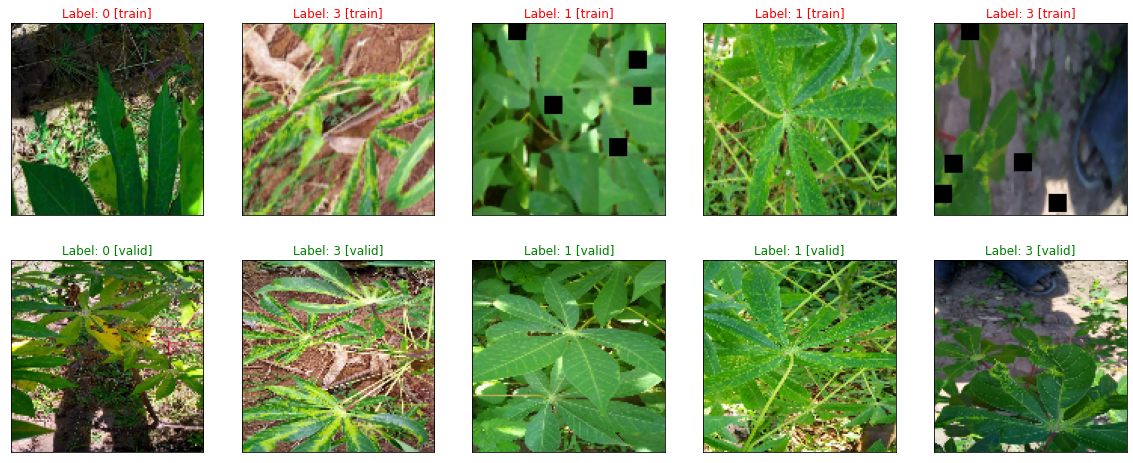

In [18]:
####### EXAMINE SAMPLE BATCH

# sample size
sample = 5

# augmentations
train_augs, test_augs = get_augs(CFG, image_size = 128)

# datasets
train_dataset = LeafData(data      = df.head(sample*2), 
                         directory = CFG['data_path'] + 'train_images/',
                         transform = train_augs,
                         labeled   = True)
test_dataset = LeafData(data       = df.head(sample*2), 
                        directory  = CFG['data_path'] + 'train_images/',
                        transform  = test_augs,
                        labeled    = True)

# data loaders
train_loader = DataLoader(dataset     = train_dataset, 
                          batch_size  = sample, 
                          shuffle       = False, 
                          num_workers = 0,
                          pin_memory  = True)
test_loader = DataLoader(dataset      = test_dataset, 
                         batch_size   = sample, 
                         shuffle        = False, 
                         num_workers  = 0,
                         pin_memory   = True)

# display train images
batch_time = time.time()
for batch_idx, (inputs, labels) in enumerate(train_loader):

    # apply cutmix augmentation
    if CFG['cutmix'][0] > 0:
        mix_decision = 0 #np.random.rand(1)
        if mix_decision < CFG['cutmix'][0]:
            inputs, _ = cutmix_fn(data   = inputs, 
                                  target = labels, 
                                  alpha  = cutmix[1])

    # feedback
    inputs_shape = inputs.shape
    load_time    = time.time() - batch_time
    pixel_values = [torch.min(inputs).item(), torch.mean(inputs).item(), torch.max(inputs).item()]

    # examples
    fig = plt.figure(figsize = (20, 8))
    for i in range(sample):
        ax = fig.add_subplot(2, sample, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title('Label: {} [train]'.format(labels[i].numpy()), color = 'red')
    break

# display test images
batch_time = time.time()
for batch_idx, (inputs, labels) in enumerate(test_loader):

    # feedback
    print('- batch shape:  {} vs {}'.format(inputs_shape, inputs.shape))
    print('- loading time: {:.4f} vs {:.4f} seconds'.format(load_time, (time.time() - batch_time)))
    print('- pixel values: {:.2f} - {:.2f} - {:.2f} vs {:.2f} - {:.2f} - {:.2f}'.format(
        pixel_values[0], pixel_values[1], pixel_values[2],
        torch.min(inputs).item(), torch.mean(inputs).item(), torch.max(inputs).item()))

    # examples
    for i in range(sample):
        ax = fig.add_subplot(2, sample, sample + i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title('Label: {} [valid]'.format(labels[i].numpy()), color = 'green')
    plt.savefig(CFG['out_path'] + 'fig_sample.png')
    break
    
# clean up
del inputs, labels, batch_idx, train_loader, test_loader, train_dataset, test_dataset, train_augs, test_augs

# MODEL PREP

In [19]:
####### MODEL ARCHITECTURE

def init_model(CFG, device, path = None):

    ##### CONVOLUTIONAL PART

    if 'deit' in CFG['backbone']: 
        model = torch.hub.load(repo_or_dir = 'facebookresearch/deit:main', 
                               model       = CFG['backbone'], 
                               pretrained  = False if (CFG['weights'] == 'empty') or (CFG['weights'] == 'custom') else True)
                 
    else:
        model = timm.create_model(model_name = CFG['backbone'], 
                                  pretrained = False if (CFG['weights'] == 'empty') or (CFG['weights'] == 'custom') else True)
        

    ##### CUSTOM WEIGHTS

    if CFG['weights'] == 'custom':

        if 'efficient' in CFG['backbone']:
            model.classifier = nn.Linear(model.classifier.in_features, CFG['pr_num_classes'])
        elif ('vit' in CFG['backbone']) or ('deit' in CFG['backbone']):
            model.head = nn.Linear(model.head.in_features, CFG['pr_num_classes'])
        else:
            model.fc = nn.Linear(model.fc.in_features, CFG['pr_num_classes'])
        
        path = 'weights_tf_efficientnet_b4_ns_pretrain.pth'
        path = 'weights_swsl_resnext50_32x4d_pretrain.pth'
        model.load_state_dict(torch.load(CFG['model_path'] + path, map_location = device))

        
    ##### CLASSIFIER PART

    if (CFG['weights'] != 'custom') or ((CFG['weights'] == 'custom') and (CFG['num_classes'] != CFG['pr_num_classes'])):
    
        if 'efficient' in CFG['backbone']:
            model.classifier = nn.Linear(model.classifier.in_features, CFG['num_classes'])
        elif ('vit' in CFG['backbone']) or ('deit' in CFG['backbone']):
            model.head = nn.Linear(model.head.in_features, CFG['num_classes'])
        else:
            model.fc = nn.Linear(model.fc.in_features, CFG['num_classes'])

    return model

In [20]:
####### MODEL INSPECTION

model_inspection = False

if model_inspection:

    # libraries
    !pip install torchsummary
    from torchsummary import summary

    # summary
    model = init_model(CFG)
    summary(model, (3, CFG['image_size'], CFG['image_size']))
    del model

In [21]:
####### LEARNING RATE FINDER

lr_finder = False

if lr_finder:

    # libraries
    !pip install torch-lr-finder
    from torch_lr_finder import LRFinder
    !pip install ipywidgets
    from ipywidgets import IntProgress

    # data loader
    dataset = LeafData(data      = df, 
                       directory = CFG['data_path'] + 'train_images/',
                       transform = train_augs,
                       labeled   = True)
    loader = DataLoader(dataset     = dataset, 
                        batch_size  = CFG['batch_size'], 
                        shuffle       = True, 
                        num_workers = CFG['num_workers'],
                        pin_memory  = True)

    # model and optimizer
    model     = init_model(CFG)
    model     = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = 1e-8)
    criterion = nn.CrossEntropyLoss().to(device)

    # LR finder
    lr_finder = LRFinder(model, optimizer, criterion, device)
    lr_finder.range_test(loader, end_lr = 10, num_iter = 100)
    lr_finder.plot() 
    lr_finder.reset()
    
    # cleanup
    del dataset, loader, model, optimizer, criterion, lr_finder

In [22]:
####### LOSS FUNCTIONS LIBRARY

##### CROSSENTROPY WITH LABEL SMOOTHING

class LabelSmoothingCrossEntropy(nn.Module):

    def __init__(self, smoothing = 0.1, reduction = 'mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        assert smoothing < 1.0
        self.smoothing  = smoothing
        self.confidence = 1. - smoothing
        self.reduction  = reduction

    def forward(self, x, target):
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss


##### OHEM LOSS

class OhemCrossEntropy(nn.Module):

    def __init__(self, top_k = 0.7, smoothing = 0, reduction = 'none'):
        super(OhemCrossEntropy, self).__init__()
        self.reduction     = reduction
        self.top_k         = top_k
        self.smoothing     = smoothing
        self.ce_lab_smooth = LabelSmoothingCrossEntropy(smoothing = self.smoothing, reduction = self.reduction)

    def forward(self, pred, target):
        log_probs = F.log_softmax(pred, dim=1)
        loss      = self.ce_lab_smooth(log_probs, target)   
        if self.top_k == 1:
            return torch.mean(loss)
        else:
            valid_loss, idxs = torch.topk(loss, int(self.top_k * loss.size()[0]))    
            return torch.mean(valid_loss)


##### SYMMETRIC CROSSENTROPY

class SymmetricCrossEntropy(nn.Module):

    def __init__(self, alpha = 0.1, beta = 1.0, num_classes = 5, smoothing = 0, reduction = 'mean'):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha         = alpha
        self.beta          = beta
        self.num_classes   = num_classes
        self.reduction     = reduction
        self.smoothing     = smoothing
        self.ce_lab_smooth = LabelSmoothingCrossEntropy(smoothing = self.smoothing, reduction = self.reduction)
        
    def forward(self, logits, targets):
        onehot_targets = torch.eye(self.num_classes)[targets].to(device)
        ce_loss  = self.ce_lab_smooth(logits, targets)
        rce_loss = (-onehot_targets*logits.softmax(1).clamp(1e-7, 1.0).log()).sum(1)
        if self.reduction == 'mean':
            rce_loss = rce_loss.mean()
        elif self.reduction == 'sum':
            rce_loss = rce_loss.sum()
        return self.alpha * ce_loss + self.beta * rce_loss


##### COMPLEMENT CROSSENTROPY

class ComplementEntropy(nn.Module):

    def __init__(self, num_classes = 5):
        super(ComplementEntropy, self).__init__()
        self.classes = num_classes
        self.batch_size = None

    def forward(self, y_hat, y):
        self.batch_size = len(y)
        y_hat = F.softmax(y_hat, dim=1)
        Yg = torch.gather(y_hat, 1, torch.unsqueeze(y, 1))
        Yg_ = (1 - Yg) + 1e-7
        Px = y_hat / Yg_.view(len(y_hat), 1)
        Px_log = torch.log(Px + 1e-10)
        y_zerohot = torch.ones(self.batch_size, self.classes).scatter_\
            (1, y.view(self.batch_size, 1).data.cpu(), 0)
        output = Px * Px_log * y_zerohot.to(device)
        entropy = torch.sum(output)
        entropy /= float(self.batch_size)
        entropy /= float(self.classes)
        return entropy

class ComplementCrossEntropy(nn.Module):

    def __init__(self, num_classes = 5, gamma = 5, smoothing = 0, reduction = 'mean'):
        super(ComplementCrossEntropy, self).__init__()
        self.gamma              = gamma
        self.smoothing          = smoothing
        self.reduction          = reduction
        self.complement_entropy = ComplementEntropy(num_classes)
        self.ce_lab_smooth      = LabelSmoothingCrossEntropy(smoothing = self.smoothing, reduction = self.reduction)

    def forward(self, y_hat, y):
        l1 = self.ce_lab_smooth(y_hat, y)
        l2 = self.complement_entropy(y_hat, y)
        return l1 + self.gamma * l2


##### FOCAL LOSS

class FocalLoss(nn.Module):
    def __init__(self, alpha = 1, gamma = 2, smoothing = 0, reduction = 'mean'):
        super(FocalLoss, self).__init__()
        self.alpha         = alpha
        self.gamma         = gamma
        self.reduction     = reduction
        self.smoothing     = smoothing
        self.ce_lab_smooth = LabelSmoothingCrossEntropy(smoothing = self.smoothing, reduction = self.reduction)

    def forward(self, inputs, targets):
        ce_loss = self.ce_lab_smooth(inputs, targets)
        pt = torch.exp(-ce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        return F_loss
        

##### FOCAL COSINE LOSS

class FocalCosineLoss(nn.Module):

    def __init__(self, alpha = 1, gamma = 2, xent = 0.1, smoothing = 0, reduction = 'mean'):
        super(FocalCosineLoss, self).__init__()
        self.alpha         = alpha
        self.gamma         = gamma
        self.xent          = xent
        self.y             = torch.Tensor([1]).to(device)
        self.reduction     = reduction
        self.smoothing     = smoothing
        self.ce_lab_smooth = LabelSmoothingCrossEntropy(smoothing = self.smoothing, reduction = 'none')

    def forward(self, input, target):
        cosine_loss = F.cosine_embedding_loss(input, F.one_hot(target, num_classes=input.size(-1)), self.y, reduction=self.reduction)
        cent_loss   = self.ce_lab_smooth(F.normalize(input), target)
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * cent_loss
        if self.reduction == "mean":
            focal_loss = torch.mean(focal_loss)
        elif self.reduction == "sum":
            focal_loss = torch.mean(focal_loss)
        return cosine_loss + self.xent * focal_loss
  
    
##### TAYLOR LOSS

class TaylorSoftmax(nn.Module):

    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out

class LabelSmoothingLoss(nn.Module):

    def __init__(self, classes, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls       = classes 
        self.dim       = dim 

    def forward(self, pred, target): 
        with torch.no_grad(): 
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

class TaylorCrossEntropyLoss(nn.Module):

    def __init__(self, n = 2, ignore_index = -1, reduction = 'mean', smoothing = 0):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction      = reduction
        self.ignore_index   = ignore_index
        self.lab_smooth     = LabelSmoothingLoss(CFG['num_classes'], smoothing = smoothing)
        self.smoothing      = smoothing

    def forward(self, logits, labels):
        log_probs = self.taylor_softmax(logits).log()
        if self.smoothing == 0:
            loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
                    ignore_index=self.ignore_index)
        else:
            loss = self.lab_smooth(log_probs, labels)
        return loss
       
    
##### BI-TEMPERED LOSS

def log_t(u, t):
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

class BiTemperedLogisticLoss(nn.Module): 
    def __init__(self, t1, t2, smoothing=0.0): 
        super(BiTemperedLogisticLoss, self).__init__() 
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing
    def forward(self, logit_label, truth_label):
        loss_label = bi_tempered_logistic_loss(
            logit_label, truth_label,
            t1=self.t1, t2=self.t2,
            label_smoothing=self.smoothing,
            reduction='none'
        )
        
        loss_label = loss_label.mean()
        return loss_label


##### ISDA LOSS

class EstimatorCV():
    
    def __init__(self, feature_num, class_num):
        super(EstimatorCV, self).__init__()
        self.class_num = class_num
        self.CoVariance = torch.zeros(class_num, feature_num, feature_num).to(device)
        self.Ave = torch.zeros(class_num, feature_num).to(device)
        self.Amount = torch.zeros(class_num).to(device)

    def update_CV(self, features, labels):
        N = features.size(0)
        C = self.class_num
        A = features.size(1)
        NxCxFeatures = features.view(
            N, 1, A
        ).expand(
            N, C, A
        )
        onehot = torch.zeros(N, C).to(device)
        onehot.scatter_(1, labels.view(-1, 1), 1)
        NxCxA_onehot = onehot.view(N, C, 1).expand(N, C, A)
        features_by_sort = NxCxFeatures.mul(NxCxA_onehot)
        Amount_CxA = NxCxA_onehot.sum(0)
        Amount_CxA[Amount_CxA == 0] = 1
        ave_CxA = features_by_sort.sum(0) / Amount_CxA
        var_temp = features_by_sort - \
                   ave_CxA.expand(N, C, A).mul(NxCxA_onehot)
        var_temp = torch.bmm(
            var_temp.permute(1, 2, 0),
            var_temp.permute(1, 0, 2)
        ).div(Amount_CxA.view(C, A, 1).expand(C, A, A))
        sum_weight_CV = onehot.sum(0).view(C, 1, 1).expand(C, A, A)
        sum_weight_AV = onehot.sum(0).view(C, 1).expand(C, A)
        weight_CV = sum_weight_CV.div(
            sum_weight_CV + self.Amount.view(C, 1, 1).expand(C, A, A)
        )
        weight_CV[weight_CV != weight_CV] = 0
        weight_AV = sum_weight_AV.div(
            sum_weight_AV + self.Amount.view(C, 1).expand(C, A)
        )
        weight_AV[weight_AV != weight_AV] = 0
        additional_CV = weight_CV.mul(1 - weight_CV).mul(
            torch.bmm(
                (self.Ave - ave_CxA).view(C, A, 1),
                (self.Ave - ave_CxA).view(C, 1, A)
            )
        )
        self.CoVariance = (self.CoVariance.mul(1 - weight_CV) + var_temp
                      .mul(weight_CV)).detach() + additional_CV.detach()
        self.Ave = (self.Ave.mul(1 - weight_AV) + ave_CxA.mul(weight_AV)).detach()
        self.Amount += onehot.sum(0)


class ISDALoss(nn.Module):
    
    def __init__(self, feature_num, class_num, smoothing):
        super(ISDALoss, self).__init__()
        self.estimator = EstimatorCV(feature_num, class_num)
        self.class_num = class_num
        self.cross_entropy = nn.LabelSmoothingCrossEntropy(smoothing = smoothing)

    def isda_aug(self, fc, features, y, labels, cv_matrix, ratio):
        N = features.size(0)
        C = self.class_num
        A = features.size(1)
        weight_m = list(fc.parameters())[0]
        NxW_ij = weight_m.expand(N, C, A)
        NxW_kj = torch.gather(NxW_ij,
                              1,
                              labels.view(N, 1, 1)
                              .expand(N, C, A))
        CV_temp = cv_matrix[labels]
        sigma2 = ratio * \
                 torch.bmm(torch.bmm(NxW_ij - NxW_kj,
                                     CV_temp),
                           (NxW_ij - NxW_kj).permute(0, 2, 1))
        sigma2 = sigma2.mul(torch.eye(C).to(device)
                            .expand(N, C, C)).sum(2).view(N, C)
        aug_result = y + 0.5 * sigma2
        return aug_result

    def forward(self, model, fc, x, target_x, ratio):
        features = model(x)
        y = fc(features)
        self.estimator.update_CV(features.detach(), target_x)
        isda_aug_y = self.isda_aug(fc, features, y, target_x, self.estimator.CoVariance.detach(), ratio)
        loss = self.cross_entropy(isda_aug_y, target_x)
        return loss, y

In [23]:
####### GRADCAM MODULES

class FeatureExtractor():
    """ Class for extracting activations and
    registering gradients from targetted intermediate layers """

    def __init__(self, model, target_layers):
        self.model = model
        self.target_layers = target_layers
        self.gradients = []

    def save_gradient(self, grad):
        self.gradients.append(grad)

    def __call__(self, x):
        outputs = []
        self.gradients = []
        for name, module in self.model._modules.items():
            x = module(x)
            if name in self.target_layers:
                x.register_hook(self.save_gradient)
                outputs += [x]
        return outputs, x


class ModelOutputs():
    """ Class for making a forward pass, and getting:
    1. The network output.
    2. Activations from intermeddiate targetted layers.
    3. Gradients from intermeddiate targetted layers. """

    def __init__(self, model, feature_module, target_layers):
        self.model = model
        self.feature_module = feature_module
        self.feature_extractor = FeatureExtractor(self.feature_module, target_layers)

    def get_gradients(self):
        return self.feature_extractor.gradients

    def __call__(self, x):
        target_activations = []
        for name, module in self.model._modules.items():
            if module == self.feature_module:
                target_activations, x = self.feature_extractor(x)
            elif "avgpool" in name.lower():
                x = module(x)
                x = x.view(x.size(0),-1)
            else:
                x = module(x)

        return target_activations, x


class GradCam():

    def __init__(self, model, feature_module, target_layer_names, use_cuda):
        self.model = model
        self.feature_module = feature_module
        self.model.eval()
        self.cuda = use_cuda
        if self.cuda:
            self.model = model.cuda()
        self.extractor = ModelOutputs(self.model, self.feature_module, target_layer_names)

    def forward(self, input_img):
        return self.model(input_img)

    def __call__(self, input_img, target_category=None):
        if self.cuda:
            input_img = input_img.cuda()

        features, output = self.extractor(input_img)

        if target_category == None:
            target_category = np.argmax(output.cpu().data.numpy())

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0][target_category] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        if self.cuda:
            one_hot = one_hot.cuda()
        
        one_hot = torch.sum(one_hot * output)

        self.feature_module.zero_grad()
        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        grads_val = self.extractor.get_gradients()[-1].cpu().data.numpy()

        target = features[-1]
        target = target.cpu().data.numpy()[0, :]

        weights = np.mean(grads_val, axis = (2, 3))[0, :]
        cam = np.zeros(target.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * target[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_img.shape[2:])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam


def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * (1 - mask)), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = np.float32(img) + 0.5 * heatmap
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# MAIN FUNCTIONS

In [24]:
####### DATA PREP

def get_data(df, fold, CFG, epoch = None):

    ##### EPOCH-BASED PARAMS

    # image size
    if (CFG['step_size']) and (epoch is not None):
        image_size = int(CFG['image_size'] * CFG['step_size'][epoch])
    else:
        image_size = CFG['image_size']

    # no. classes
    if (CFG['step_class']) and (epoch is not None):
        num_classes = CFG['step_class'][epoch]
    else:
        num_classes = CFG['num_classes']

    # augmentation probability
    if (CFG['step_p_aug']) and (epoch is not None):
        p_augment = CFG['p_augment'] * CFG['step_p_aug'][epoch]
    else:
        p_augment = CFG['p_augment']


    ##### PARTITIONING

    # load splits
    df_train = df.loc[df.fold != fold].reset_index(drop = True)
    df_valid = df.loc[df.fold == fold].reset_index(drop = True)     
    if epoch is None:  
        smart_print('-- no. images: train - {}, valid - {}'.format(len(df_train), len(df_valid)), CFG)

    # 2019 labeled data
    if CFG['data_2019']:
        df_train = pd.concat([df_train, df_2019], axis = 0).reset_index(drop = True)
        if epoch is None:  
            smart_print('- appending 2019 labeled data to train...', CFG)
            smart_print('-- no. images: train - {}, valid - {}'.format(len(df_train), len(df_valid)), CFG)

    # 2019 psueudo-labeled data
    if CFG['data_pl']:
        df_train = pd.concat([df_train, df_pl], axis = 0).reset_index(drop = True)
        if epoch is None:  
            smart_print('- appending 2019 pseudo-labeled data to train...', CFG)
            smart_print('-- no. images: train - {}, valid - {}'.format(len(df_train), len(df_valid)), CFG)

    # external data
    if CFG['data_ext']:
        df_train = pd.concat([df_train, df_ext], axis = 0).reset_index(drop = True)
        if epoch is None:  
            smart_print('- appending external data to train...', CFG)
            smart_print('-- no. images: train - {}, valid - {}'.format(len(df_train), len(df_valid)), CFG)


    ##### SUBSETTING

    # removing bad examples
    if CFG['drop_dupl']:
        df_train = df_train.loc[~df_train.image_id.isin(list_dupl)].reset_index(drop = True)
    if CFG['drop_outs']:
        df_train = df_train.loc[~df_train.image_id.isin(list_outs)].reset_index(drop = True)
    if CFG['drop_noise']:
        list_noise = list(df_no['image_id'].values)
        df_train   = df_train.loc[~df_train.image_id.isin(list_noise)].reset_index(drop = True)
    if CFG['flip_noise']:
        list_noise = [img for img in df_no['image_id'].values if img in df_train['image_id'].values]
        for img in list_noise:
            df_train.loc[df_train.image_id == img, 'label'] = df_no.loc[df_no.image_id == img, 'pred'].astype('int').values
    if epoch is None:  
        smart_print('- dealing with bad images from train...', CFG)
        smart_print('-- no. images: train - {}, valid - {}'.format(len(df_train), len(df_valid)), CFG)

    # subset for debug mode
    if CFG['debug']:
        df_train = df_train.sample(CFG['batch_size'] * 5, random_state = CFG['seed']).reset_index(drop = True)
        df_valid = df_valid.sample(CFG['batch_size'] * 5, random_state = CFG['seed']).reset_index(drop = True)


    ##### DATASETS
    
    # target transformation
    if num_classes == 2:
        mapping = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 1}
        df_train['label'] = df_train['label'].map(mapping) 
        df_valid['label'] = df_valid['label'].map(mapping) 
        
    # augmentations
    train_augs, test_augs = get_augs(CFG, image_size, p_augment)

    # datasets
    train_dataset = LeafData(data      = df_train, 
                             directory = CFG['data_path'] + 'train_images/',
                             transform = train_augs,
                             labeled   = True)
    valid_dataset = LeafData(data      = df_valid, 
                             directory = CFG['data_path'] + 'train_images/',
                             transform = test_augs,
                             labeled   = True)
    
    
    ##### DATA SAMPLERS
    
    ### GPU SAMPLERS
    if CFG['device'] != 'TPU':
    
        # samplers with oversampling 
        if CFG['oversample']:
            weights        = 1. / torch.tensor(df_train['label'].value_counts(sort = False).values, dtype = torch.float)
            sample_weights = weights[df_train['label']]
            train_sampler  = WeightedRandomSampler(weights     = sample_weights,
                                                   num_samples = len(sample_weights),
                                                   replacement = True)
            valid_sampler = SequentialSampler(valid_dataset)

        # ordinary samplers
        else:
            train_sampler = RandomSampler(train_dataset)
            valid_sampler = SequentialSampler(valid_dataset)
        
    ### TPU SAMPLERS  
    if CFG['device'] == 'TPU':
        
        # distributed samplers
        train_sampler = DistributedSampler(train_dataset,
                                           num_replicas = xm.xrt_world_size(),
                                           rank         = xm.get_ordinal(),
                                           shuffle        = True)
        valid_sampler = DistributedSampler(valid_dataset,
                                           num_replicas = xm.xrt_world_size(),
                                           rank         = xm.get_ordinal(),
                                           shuffle        = False)
        
    ##### DATA LOADERS
       
    # data loaders
    train_loader = DataLoader(dataset     = train_dataset, 
                              batch_size  = CFG['batch_size'], 
                              sampler     = train_sampler,
                              num_workers = CFG['num_workers'],
                              pin_memory  = True)
    valid_loader = DataLoader(dataset     = valid_dataset, 
                              batch_size  = CFG['batch_size'], 
                              sampler     = valid_sampler, 
                              num_workers = CFG['num_workers'],
                              pin_memory  = True)
    
    # feedback
    if epoch is None:
        smart_print('-' * 55, CFG)
    smart_print('-- size: {}x{}, classes: {}, p(augment): {}'.format(image_size, image_size, num_classes, p_augment), CFG)

    # output
    return train_loader, valid_loader, df_train, df_valid

In [25]:
####### LOSS PREP

def get_losses(CFG, device, epoch = None):

    # look up training loss
    if CFG['step_loss'] and epoch is not None:
        loss_fn = CFG['step_loss'][epoch]
    else:
        loss_fn = CFG['loss_fn']

    # define training loss
    if loss_fn == 'CE':
        trn_criterion = LabelSmoothingCrossEntropy(smoothing = CFG['smoothing']).to(device)

    elif loss_fn == 'OHEM':
        trn_criterion = OhemCrossEntropy(top_k     = CFG['ohem'], 
                                         smoothing = CFG['smoothing']).to(device)

    elif loss_fn == 'SCE':
        trn_criterion = SymmetricCrossEntropy(alpha       = CFG['sce'][0],
                                              beta        = CFG['sce'][1],
                                              num_classes = CFG['num_classes'],
                                              smoothing   = CFG['smoothing']).to(device)

    elif loss_fn == 'CCE':
        trn_criterion = ComplementCrossEntropy(gamma       = CFG['cce'],
                                               num_classes = CFG['num_classes'],
                                               smoothing   = CFG['smoothing']).to(device)

    elif loss_fn == 'Focal':
        trn_criterion = FocalLoss(alpha     = CFG['focal'][0],
                                  gamma     = CFG['focal'][1],
                                  smoothing = CFG['smoothing']).to(device)

    elif loss_fn == 'FocalCosine':
        trn_criterion = FocalCosineLoss(alpha     = CFG['focalcosine'][0],
                                        gamma     = CFG['focalcosine'][1],
                                        xent      = CFG['focalcosine'][2],
                                        smoothing = CFG['smoothing']).to(device)

    elif loss_fn == 'Taylor':
        trn_criterion = TaylorCrossEntropyLoss(n         = CFG['taylor'], 
                                               smoothing = CFG['smoothing']).to(device)

    elif loss_fn == 'BiTempered':
        trn_criterion = BiTemperedLogisticLoss(t1        = CFG['bitempered'][0], 
                                               t2        = CFG['bitempered'][1], 
                                               smoothing = CFG['smoothing'])


    # define validation loss
    val_criterion = nn.CrossEntropyLoss().to(device)

    # output
    return trn_criterion, val_criterion

In [26]:
####### MODEL PREP

def get_model(CFG, device, epoch = None):

    ##### MODEL

    # initialize model
    model = init_model(CFG, device)

    # send to device
    if CFG['device'] != 'TPU':
        model = model.to(device)
    else:
        mx    = xmp.MpModelWrapper(model)
        model = mx.to(device)

    # freezing deep layers
    if epoch is not None:
        if (CFG['fine_tune']) and (epoch >= CFG['num_epochs']):
            for name, child in model.named_children():
                if name not in ['classifier', 'fc', 'head']:
                    for param in child.parameters():
                        param.requires_grad = False
            eta = CFG['eta_min']


    ##### OPTIMIZER

    # scale learning rates
    if CFG['device'] == 'TPU':
        eta     = CFG['eta']     * xm.xrt_world_size()
        eta_min = CFG['eta_min'] * xm.xrt_world_size()
    else:
        eta     = CFG['eta']
        eta_min = CFG['eta_min']

    # optimizer
    if CFG['optim'] == 'Adam':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = eta, weight_decay = CFG['decay'])
    elif CFG['optim'] == 'AdamW':
        optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr = eta, weight_decay = CFG['decay'])
    elif CFG['optim'] == 'AdamP':
        optimizer = AdamP(filter(lambda p: p.requires_grad, model.parameters()), lr = eta, weight_decay = CFG['decay'])


    ##### SCHEDULER

    # after scheduler
    if CFG['schedule'] == 'CosineAnnealing':
        after_scheduler = CosineAnnealingWarmRestarts(optimizer = optimizer,
                                                      T_0       = CFG['num_epochs'] - CFG['warmup'] if CFG['num_epochs'] > 1 else 1,
                                                      eta_min   = eta_min)
        
    # warmup
    scheduler = GradualWarmupScheduler(optimizer       = optimizer, 
                                       multiplier      = 1, 
                                       total_epoch     = CFG['warmup'] + 1, 
                                       after_scheduler = after_scheduler)

    # output
    return model, optimizer, scheduler

In [27]:
####### TRAINING

def train_epoch(loader, model, optimizer, scheduler, criterion, epoch, CFG, device):
       
    # switch regime
    model.train()

    # running loss
    trn_loss = AverageMeter()

    # update scheduler on epoch
    if not CFG['update_on_batch']:
        scheduler.step() 
        if epoch == CFG['warmup']:
            scheduler.step() 

    # loop through batches
    for batch_idx, (inputs, labels) in (tqdm(enumerate(loader), total = len(loader)) if CFG['device'] != 'TPU' \
                                        else enumerate(loader)):

        # extract inputs and labels
        inputs = inputs.to(device)
        labels = labels.to(device)

        # apply cutmix augmentation
        if CFG['cutmix'][0] > 0:
            mix_decision = np.random.rand(1)
            if mix_decision < CFG['cutmix'][0]:
                inputs, labels = cutmix_fn(data   = inputs, 
                                           target = labels, 
                                           alpha  = cutmix[1])
        else:
            mix_decision = 0

        # update scheduler on batch
        if CFG['update_on_batch']:
            scheduler.step(epoch + 1 + batch_idx / len(loader))

        # passes and weight updates
        with torch.set_grad_enabled(True):
            
            # forward pass 
            with amp_autocast():
                preds = model(inputs)
                if (CFG['cutmix'][0] > 0) and (mix_decision < CFG['cutmix'][0]):
                    loss = criterion(preds, labels[0]) * labels[2] + criterion(preds, labels[1]) * (1. - labels[2])
                else:
                    loss = criterion(preds, labels)
                    
            # backward pass
            if CFG['use_amp']:
                scaler.scale(loss).backward()   
            else:
                loss.backward() 

            # update weights
            if ((batch_idx + 1) % CFG['accum_iter'] == 0) or ((batch_idx + 1) == len(loader)):
                if CFG['device'] == 'TPU':
                    xm.optimizer_step(optimizer, barrier = True)
                else:
                    if CFG['use_amp']:
                        scaler.step(optimizer)
                        scaler.update()
                    else:
                        optimizer.step()
                optimizer.zero_grad()

        # update loss
        trn_loss.update(loss.item(), inputs.size(0))

        # clear memory
        del inputs, labels, preds, loss
        gc.collect()

    # output
    return trn_loss.sum

In [28]:
####### INFERENCE

def valid_epoch(loader, model, criterion, CFG, device):

    # switch regime
    model.eval()

    # running loss
    val_loss = AverageMeter()

    # preds placeholders
    PROBS = []
       
    # loop through batches
    with torch.no_grad():
        for batch_idx, (inputs, labels) in (tqdm(enumerate(loader), total = len(loader)) if CFG['device'] != 'TPU' \
                                            else enumerate(loader)):

            # extract inputs and labels
            inputs = inputs.to(device)
            labels = labels.to(device)

            # preds placeholders
            logits = torch.zeros((inputs.shape[0], CFG['num_classes']), device = device)
            probs  = torch.zeros((inputs.shape[0], CFG['num_classes']), device = device)

            # compute predictions
            for tta_idx in range(CFG['num_tta']): 
                preds   = model(get_tta_flips(inputs, tta_idx))
                logits += preds / CFG['num_tta']
                probs  += preds.softmax(axis = 1) / CFG['num_tta']

            # compute loss
            loss = criterion(logits, labels)
            val_loss.update(loss.item(), inputs.size(0))

            # store predictions
            PROBS.append(probs.detach().cpu())

            # clear memory
            del inputs, labels, preds, loss
            gc.collect()

    # transform predictions
    PROBS = torch.cat(PROBS).numpy()

    # output
    return val_loss.sum, PROBS

In [29]:
####### WRAPPER FUNCTION

def run_fold(fold, trn_loader, val_loader, df_trn, df_val, CFG, device):

    ##### PREPARATIONS
    
    # reset seed
    seed_everything(CFG['seed'] + fold, CFG)

    # get model
    model, optimizer, scheduler = get_model(CFG, device)
        
    # placeholders
    trn_losses  = []
    val_losses  = []
    val_metrics = []
    lrs         = []

    
    ##### TRAINING AND INFERENCE

    for epoch in range(CFG['num_epochs'] + CFG['fine_tune']):
                
        ### PREPARATIONS

        # timer
        epoch_start = time.time()

        # update data loaders if needed
        if (CFG['step_size']) or (CFG['step_class']) or (CFG['step_p_aug']):
            trn_loader, val_loader, _, _ = get_data(df, fold, CFG, epoch)   

        # freeze layers if needed
        if (CFG['fine_tune']) and (epoch == CFG['num_epochs']):
            model, optimizer, scheduler = get_model(CFG, device, epoch)
            model.load_state_dict(torch.load(CFG['out_path'] + 'weights_fold{}.pth'.format(fold),
                                             map_location = device))
            
        # get losses
        if epoch < CFG['num_epochs']:
            trn_criterion, val_criterion = get_losses(CFG, device, epoch)


        ### MODELING

        # training
        gc.collect()
        if CFG['training']:
            if CFG['device'] == 'TPU':
                pl_loader = pl.ParallelLoader(trn_loader, [device])
            trn_loss = train_epoch(loader     = trn_loader if CFG['device'] != 'TPU' else pl_loader.per_device_loader(device), 
                                   model      = model, 
                                   optimizer  = optimizer, 
                                   scheduler  = scheduler,
                                   criterion  = trn_criterion, 
                                   epoch      = epoch,
                                   CFG        = CFG,
                                   device     = device)
        else:
            model.load_state_dict(torch.load(CFG['out_path'] + 'weights_fold{}.pth'.format(fold),
                                             map_location = device))
            trn_loss = np.nan

        # inference
        gc.collect()
        if CFG['device'] == 'TPU':
            pl_loader = pl.ParallelLoader(val_loader, [device])
        val_loss, val_preds = valid_epoch(loader    = val_loader if CFG['device'] != 'TPU' else pl_loader.per_device_loader(device), 
                                          model     = model, 
                                          criterion = val_criterion, 
                                          CFG       = CFG,
                                          device    = device)
        

        ### EVALUATION
        
        # reduce losses
        if CFG['device'] == 'TPU':
            trn_loss = xm.mesh_reduce('loss', trn_loss, lambda x: sum(x) / (len(df_trn) * xm.xrt_world_size()))
            val_loss = xm.mesh_reduce('loss', val_loss, lambda x: sum(x) / (len(df_val) * xm.xrt_world_size()))
            lr       = scheduler.state_dict()['_last_lr'][0] / xm.xrt_world_size()
        else:
            trn_loss = trn_loss / len(df_trn)
            val_loss = val_loss / len(df_val)
            lr       = scheduler.state_dict()['_last_lr'][0]
            
        # save LR and losses
        lrs.append(lr)
        trn_losses.append(trn_loss)
        val_losses.append(val_loss)
        val_metrics.append((np.argmax(val_preds, axis = 1) == df_val['label']).sum() / len(df_val))
        
        # feedback
        smart_print('- epoch {}/{} | lr = {:.6f} | trn_loss = {:.4f} | val_loss = {:.4f} | val_acc = {:.4f} | {:.2f} min'.format(
            epoch + 1, CFG['num_epochs'] + CFG['fine_tune'], lrs[epoch],
            trn_losses[epoch], val_losses[epoch], val_metrics[epoch],
            (time.time() - epoch_start) / 60), CFG)
        
        # send to neptune
        if CFG['tracking']:
            neptune.send_metric('val_loss{}'.format(fold), val_losses[epoch])
            neptune.send_metric('val_acc{}'.format(fold),  val_metrics[epoch])
        
        # export weights and save preds
        if val_metrics[epoch] >= max(val_metrics):
            smart_save(model.state_dict(), CFG['out_path'] + 'weights_fold{}.pth'.format(fold), CFG)
            val_preds_best = val_preds.copy()
        if CFG['save_all']:
            smart_save(model.state_dict(), CFG['out_path'] + 'weights_fold{}_epoch{}.pth'.format(fold, epoch), CFG)      
            
    
    return trn_losses, val_losses, val_metrics, val_preds_best

In [30]:
####### PLOTTING FUNCTION

def plot_results(trn_losses, val_losses, val_metrics, fold, CFG):

    # plot loss lines
    plt.figure(figsize = (20, 8))
    plt.plot(range(1, CFG['num_epochs'] + CFG['fine_tune'] + 1), trn_losses, color = 'red',   label = 'Train Loss')
    plt.plot(range(1, CFG['num_epochs'] + CFG['fine_tune'] + 1), val_losses, color = 'green', label = 'Valid Loss') 

    # plot points with the best losses
    x = np.argmin(np.array(val_losses)) + 1; y = min(val_losses)
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s = 200, color = 'green')
    plt.text(x - 0.04*xdist, y - 0.045*ydist, 'loss = {:.4f}'.format(y), size = 15)

    # annotations
    plt.ylabel('Loss', size = 14); plt.xlabel('Epoch', size = 14)
    plt.legend(loc = 2, fontsize = 'large')

    # plot metric line
    plt2 = plt.gca().twinx()
    plt2.plot(range(1, CFG['num_epochs'] + CFG['fine_tune'] + 1), val_metrics, color = 'blue', label = 'Valid Accuracy')

    # plot points with the best metric
    x = np.argmax(np.array(val_metrics)) + 1; y = max(val_metrics)
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x, y, s = 200, color = 'blue')
    plt.text(x - 0.05*xdist, y - 0.045*ydist, 'acc = {:.4f}'.format(y), size = 15)

    # annotations
    plt.ylabel('Accuracy', size = 14)
    plt.title('Fold {}: Performance Dynamics'.format(fold), size = 18)
    plt.legend(loc = 3, fontsize = 'large')

    # export
    plt.savefig(CFG['out_path'] + 'fig_perf_fold{}.png'.format(fold))
    plt.show()

# CROSS-VALIDATION

-------------------------------------------------------
FOLD 1/5
-------------------------------------------------------
-- no. images: train - 17117, valid - 4280
- appending 2019 labeled data to train...
-- no. images: train - 22773, valid - 4280
- appending 2019 pseudo-labeled data to train...
-- no. images: train - 26046, valid - 4280
- dealing with bad images from train...
-- no. images: train - 26000, valid - 4280
-------------------------------------------------------
-- size: 512x512, classes: 5, p(augment): 0.5
Setting random seed to 13353...


100%|██████████| 134/134 [00:50<00:00,  2.67it/s]


- epoch 1/12 | lr = 0.000100 | trn_loss = 0.9751 | val_loss = 0.5350 | val_acc = 0.8640 | 13.63 min


100%|██████████| 134/134 [00:50<00:00,  2.66it/s]


- epoch 2/12 | lr = 0.000097 | trn_loss = 0.9150 | val_loss = 0.5142 | val_acc = 0.8710 | 13.59 min


100%|██████████| 134/134 [00:52<00:00,  2.58it/s]

- epoch 3/12 | lr = 0.000088 | trn_loss = 0.8955 | val_loss = 0.5061 | val_acc = 0.8647 | 13.58 min



100%|██████████| 134/134 [00:50<00:00,  2.63it/s]


- epoch 4/12 | lr = 0.000075 | trn_loss = 0.8858 | val_loss = 0.4756 | val_acc = 0.8790 | 13.67 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 5/12 | lr = 0.000059 | trn_loss = 0.8699 | val_loss = 0.4704 | val_acc = 0.8797 | 13.59 min


100%|██████████| 134/134 [00:50<00:00,  2.66it/s]


- epoch 6/12 | lr = 0.000042 | trn_loss = 0.8610 | val_loss = 0.4531 | val_acc = 0.8832 | 13.57 min


100%|██████████| 134/134 [00:51<00:00,  2.62it/s]


- epoch 7/12 | lr = 0.000026 | trn_loss = 0.8487 | val_loss = 0.4561 | val_acc = 0.8864 | 13.60 min


100%|██████████| 134/134 [00:50<00:00,  2.67it/s]


- epoch 8/12 | lr = 0.000013 | trn_loss = 0.8383 | val_loss = 0.4388 | val_acc = 0.8888 | 13.58 min


100%|██████████| 134/134 [00:50<00:00,  2.65it/s]


- epoch 9/12 | lr = 0.000004 | trn_loss = 0.8327 | val_loss = 0.4400 | val_acc = 0.8883 | 13.66 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 10/12 | lr = 0.000001 | trn_loss = 0.8286 | val_loss = 0.4350 | val_acc = 0.8876 | 13.55 min


100%|██████████| 134/134 [00:50<00:00,  2.63it/s]


- epoch 11/12 | lr = 0.000097 | trn_loss = 0.8357 | val_loss = 0.4318 | val_acc = 0.8881 | 4.84 min


100%|██████████| 134/134 [00:50<00:00,  2.63it/s]


- epoch 12/12 | lr = 0.000088 | trn_loss = 0.8339 | val_loss = 0.4301 | val_acc = 0.8890 | 4.65 min
-------------------------------------------------------
Best: acc = 0.8890 (epoch 12), loss = 0.4301 (epoch 12)
-------------------------------------------------------


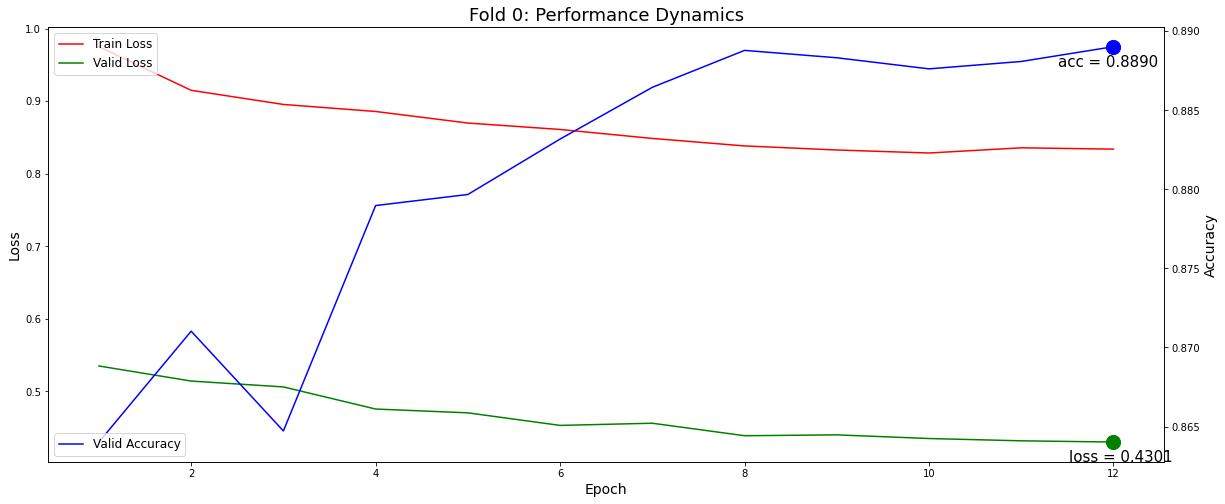

-------------------------------------------------------
FOLD 2/5
-------------------------------------------------------
-- no. images: train - 17117, valid - 4280
- appending 2019 labeled data to train...
-- no. images: train - 22773, valid - 4280
- appending 2019 pseudo-labeled data to train...
-- no. images: train - 26046, valid - 4280
- dealing with bad images from train...
-- no. images: train - 25998, valid - 4280
-------------------------------------------------------
-- size: 512x512, classes: 5, p(augment): 0.5
Setting random seed to 13354...


100%|██████████| 134/134 [00:50<00:00,  2.68it/s]


- epoch 1/12 | lr = 0.000100 | trn_loss = 0.9801 | val_loss = 0.5057 | val_acc = 0.8498 | 13.60 min


100%|██████████| 134/134 [00:50<00:00,  2.65it/s]


- epoch 2/12 | lr = 0.000097 | trn_loss = 0.9145 | val_loss = 0.4986 | val_acc = 0.8568 | 13.63 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 3/12 | lr = 0.000088 | trn_loss = 0.9001 | val_loss = 0.4616 | val_acc = 0.8645 | 13.66 min


100%|██████████| 134/134 [00:50<00:00,  2.67it/s]


- epoch 4/12 | lr = 0.000075 | trn_loss = 0.8846 | val_loss = 0.4606 | val_acc = 0.8773 | 13.64 min


100%|██████████| 134/134 [00:49<00:00,  2.68it/s]


- epoch 5/12 | lr = 0.000059 | trn_loss = 0.8745 | val_loss = 0.4450 | val_acc = 0.8883 | 13.69 min


100%|██████████| 134/134 [00:50<00:00,  2.68it/s]


- epoch 6/12 | lr = 0.000042 | trn_loss = 0.8640 | val_loss = 0.4468 | val_acc = 0.8883 | 13.73 min


100%|██████████| 134/134 [00:50<00:00,  2.65it/s]


- epoch 7/12 | lr = 0.000026 | trn_loss = 0.8507 | val_loss = 0.4456 | val_acc = 0.8871 | 13.77 min


100%|██████████| 134/134 [00:50<00:00,  2.65it/s]


- epoch 8/12 | lr = 0.000013 | trn_loss = 0.8412 | val_loss = 0.4347 | val_acc = 0.8960 | 13.78 min


100%|██████████| 134/134 [00:52<00:00,  2.53it/s]


- epoch 9/12 | lr = 0.000004 | trn_loss = 0.8325 | val_loss = 0.4252 | val_acc = 0.8925 | 13.79 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 10/12 | lr = 0.000001 | trn_loss = 0.8286 | val_loss = 0.4260 | val_acc = 0.8939 | 13.73 min


100%|██████████| 134/134 [00:50<00:00,  2.66it/s]


- epoch 11/12 | lr = 0.000097 | trn_loss = 0.8358 | val_loss = 0.4364 | val_acc = 0.8939 | 4.79 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 12/12 | lr = 0.000088 | trn_loss = 0.8354 | val_loss = 0.4230 | val_acc = 0.8956 | 4.68 min
-------------------------------------------------------
Best: acc = 0.8960 (epoch 8), loss = 0.4230 (epoch 12)
-------------------------------------------------------


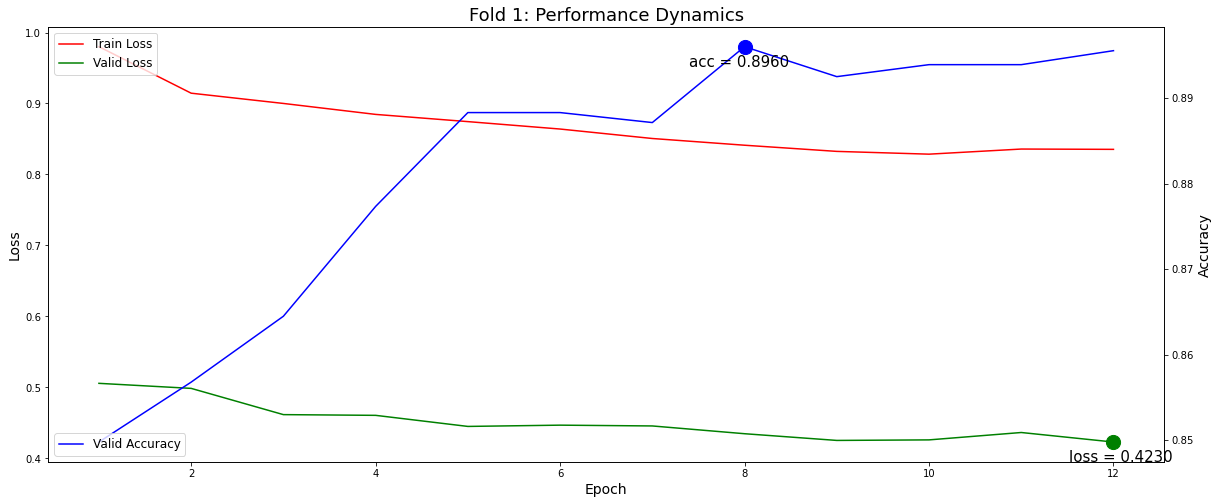

-------------------------------------------------------
FOLD 3/5
-------------------------------------------------------
-- no. images: train - 17118, valid - 4279
- appending 2019 labeled data to train...
-- no. images: train - 22774, valid - 4279
- appending 2019 pseudo-labeled data to train...
-- no. images: train - 26047, valid - 4279
- dealing with bad images from train...
-- no. images: train - 25998, valid - 4279
-------------------------------------------------------
-- size: 512x512, classes: 5, p(augment): 0.5
Setting random seed to 13355...


100%|██████████| 134/134 [00:50<00:00,  2.66it/s]


- epoch 1/12 | lr = 0.000100 | trn_loss = 0.9722 | val_loss = 0.5058 | val_acc = 0.8579 | 13.64 min


100%|██████████| 134/134 [00:50<00:00,  2.63it/s]


- epoch 2/12 | lr = 0.000097 | trn_loss = 0.9132 | val_loss = 0.4871 | val_acc = 0.8724 | 13.65 min


100%|██████████| 134/134 [00:49<00:00,  2.71it/s]


- epoch 3/12 | lr = 0.000088 | trn_loss = 0.8984 | val_loss = 0.4573 | val_acc = 0.8794 | 13.56 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 4/12 | lr = 0.000075 | trn_loss = 0.8881 | val_loss = 0.4481 | val_acc = 0.8801 | 13.53 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 5/12 | lr = 0.000059 | trn_loss = 0.8736 | val_loss = 0.4617 | val_acc = 0.8829 | 13.67 min


100%|██████████| 134/134 [00:50<00:00,  2.65it/s]


- epoch 6/12 | lr = 0.000042 | trn_loss = 0.8615 | val_loss = 0.4646 | val_acc = 0.8799 | 13.63 min


100%|██████████| 134/134 [00:50<00:00,  2.67it/s]


- epoch 7/12 | lr = 0.000026 | trn_loss = 0.8512 | val_loss = 0.4384 | val_acc = 0.8892 | 13.61 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 8/12 | lr = 0.000013 | trn_loss = 0.8418 | val_loss = 0.4293 | val_acc = 0.8902 | 13.66 min


100%|██████████| 134/134 [00:50<00:00,  2.65it/s]


- epoch 9/12 | lr = 0.000004 | trn_loss = 0.8344 | val_loss = 0.4357 | val_acc = 0.8925 | 13.59 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 10/12 | lr = 0.000001 | trn_loss = 0.8281 | val_loss = 0.4288 | val_acc = 0.8918 | 13.64 min


100%|██████████| 134/134 [00:50<00:00,  2.63it/s]


- epoch 11/12 | lr = 0.000097 | trn_loss = 0.8303 | val_loss = 0.4394 | val_acc = 0.8916 | 5.48 min


100%|██████████| 134/134 [00:51<00:00,  2.61it/s]


- epoch 12/12 | lr = 0.000088 | trn_loss = 0.8304 | val_loss = 0.4269 | val_acc = 0.8932 | 4.87 min
-------------------------------------------------------
Best: acc = 0.8932 (epoch 12), loss = 0.4269 (epoch 12)
-------------------------------------------------------


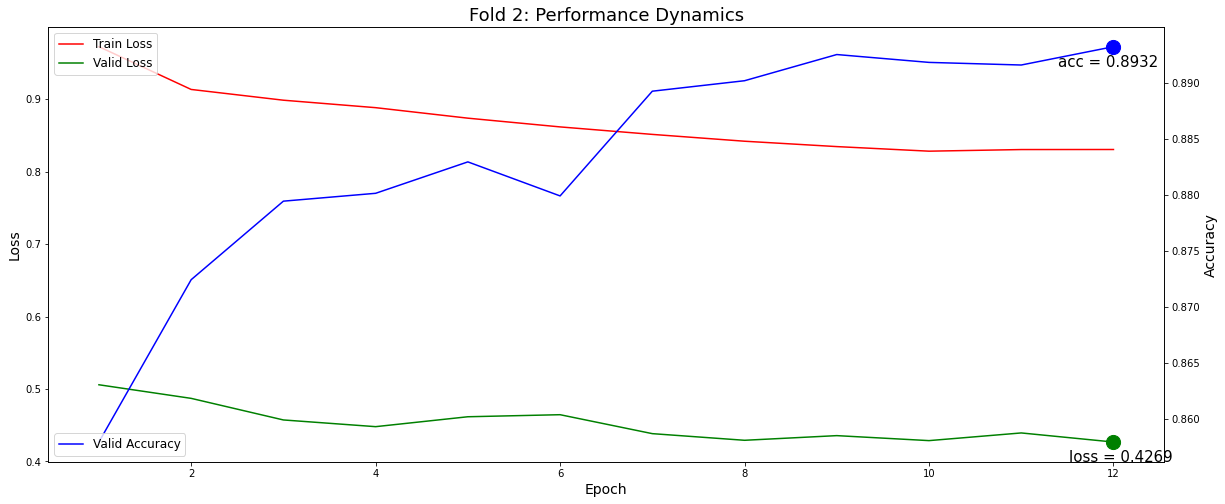

-------------------------------------------------------
FOLD 4/5
-------------------------------------------------------
-- no. images: train - 17118, valid - 4279
- appending 2019 labeled data to train...
-- no. images: train - 22774, valid - 4279
- appending 2019 pseudo-labeled data to train...
-- no. images: train - 26047, valid - 4279
- dealing with bad images from train...
-- no. images: train - 25998, valid - 4279
-------------------------------------------------------
-- size: 512x512, classes: 5, p(augment): 0.5
Setting random seed to 13356...


100%|██████████| 134/134 [00:50<00:00,  2.65it/s]


- epoch 1/12 | lr = 0.000100 | trn_loss = 0.9748 | val_loss = 0.4869 | val_acc = 0.8729 | 13.59 min


100%|██████████| 134/134 [00:50<00:00,  2.65it/s]


- epoch 2/12 | lr = 0.000097 | trn_loss = 0.9179 | val_loss = 0.4814 | val_acc = 0.8675 | 13.56 min


100%|██████████| 134/134 [00:52<00:00,  2.54it/s]


- epoch 3/12 | lr = 0.000088 | trn_loss = 0.8967 | val_loss = 0.4506 | val_acc = 0.8733 | 13.68 min


100%|██████████| 134/134 [00:50<00:00,  2.63it/s]


- epoch 4/12 | lr = 0.000075 | trn_loss = 0.8866 | val_loss = 0.4846 | val_acc = 0.8766 | 13.64 min


100%|██████████| 134/134 [00:51<00:00,  2.62it/s]


- epoch 5/12 | lr = 0.000059 | trn_loss = 0.8737 | val_loss = 0.4522 | val_acc = 0.8843 | 13.67 min


100%|██████████| 134/134 [00:51<00:00,  2.60it/s]


- epoch 6/12 | lr = 0.000042 | trn_loss = 0.8624 | val_loss = 0.4625 | val_acc = 0.8841 | 13.65 min


100%|██████████| 134/134 [00:50<00:00,  2.65it/s]


- epoch 7/12 | lr = 0.000026 | trn_loss = 0.8535 | val_loss = 0.4322 | val_acc = 0.8930 | 13.60 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 8/12 | lr = 0.000013 | trn_loss = 0.8385 | val_loss = 0.4216 | val_acc = 0.8951 | 13.58 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 9/12 | lr = 0.000004 | trn_loss = 0.8334 | val_loss = 0.4271 | val_acc = 0.8986 | 13.62 min


100%|██████████| 134/134 [00:51<00:00,  2.61it/s]


- epoch 10/12 | lr = 0.000001 | trn_loss = 0.8312 | val_loss = 0.4257 | val_acc = 0.8997 | 13.68 min


100%|██████████| 134/134 [00:50<00:00,  2.66it/s]


- epoch 11/12 | lr = 0.000097 | trn_loss = 0.8306 | val_loss = 0.4093 | val_acc = 0.8981 | 4.68 min


100%|██████████| 134/134 [00:50<00:00,  2.64it/s]


- epoch 12/12 | lr = 0.000088 | trn_loss = 0.8316 | val_loss = 0.4263 | val_acc = 0.8972 | 4.66 min
-------------------------------------------------------
Best: acc = 0.8997 (epoch 10), loss = 0.4093 (epoch 11)
-------------------------------------------------------


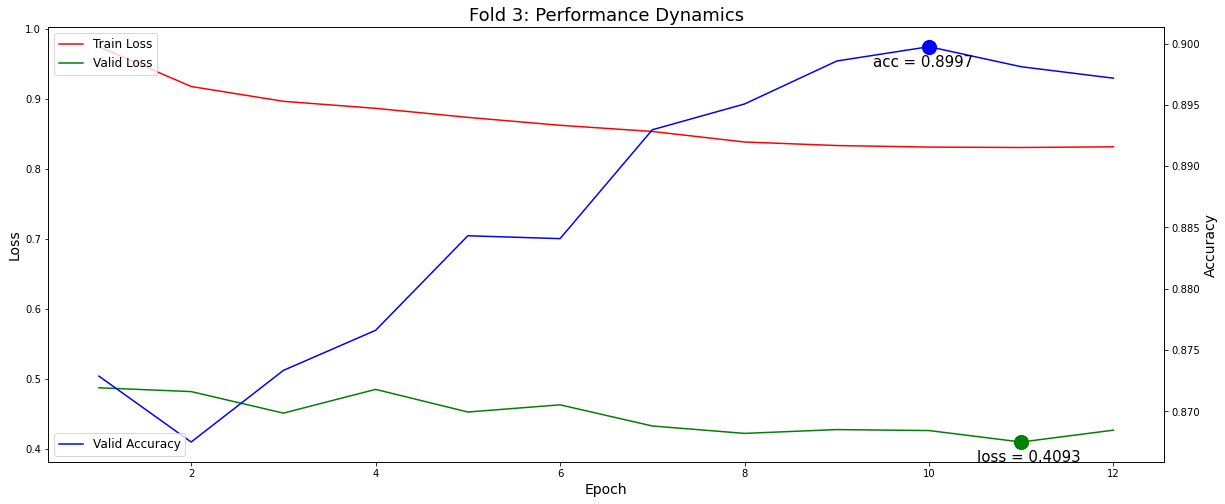

-------------------------------------------------------
FOLD 5/5
-------------------------------------------------------
-- no. images: train - 17118, valid - 4279
- appending 2019 labeled data to train...
-- no. images: train - 22774, valid - 4279
- appending 2019 pseudo-labeled data to train...
-- no. images: train - 26047, valid - 4279
- dealing with bad images from train...
-- no. images: train - 26000, valid - 4279
-------------------------------------------------------
-- size: 512x512, classes: 5, p(augment): 0.5
Setting random seed to 13357...


100%|██████████| 134/134 [00:50<00:00,  2.66it/s]


- epoch 1/12 | lr = 0.000100 | trn_loss = 0.9714 | val_loss = 0.5199 | val_acc = 0.8593 | 13.59 min


100%|██████████| 134/134 [01:05<00:00,  2.06it/s]


- epoch 2/12 | lr = 0.000097 | trn_loss = 0.9182 | val_loss = 0.4729 | val_acc = 0.8747 | 13.86 min


100%|██████████| 134/134 [01:26<00:00,  1.55it/s]


- epoch 3/12 | lr = 0.000088 | trn_loss = 0.8986 | val_loss = 0.4908 | val_acc = 0.8773 | 22.24 min


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


- epoch 4/12 | lr = 0.000075 | trn_loss = 0.8870 | val_loss = 0.4308 | val_acc = 0.8876 | 27.11 min


100%|██████████| 134/134 [01:25<00:00,  1.57it/s]


- epoch 5/12 | lr = 0.000059 | trn_loss = 0.8708 | val_loss = 0.4337 | val_acc = 0.8885 | 27.28 min


100%|██████████| 134/134 [01:25<00:00,  1.56it/s]


- epoch 6/12 | lr = 0.000042 | trn_loss = 0.8615 | val_loss = 0.4515 | val_acc = 0.8909 | 27.14 min


100%|██████████| 134/134 [01:26<00:00,  1.55it/s]


- epoch 7/12 | lr = 0.000026 | trn_loss = 0.8540 | val_loss = 0.4429 | val_acc = 0.8927 | 27.23 min


100%|██████████| 134/134 [01:26<00:00,  1.54it/s]


- epoch 8/12 | lr = 0.000013 | trn_loss = 0.8415 | val_loss = 0.4229 | val_acc = 0.8990 | 27.31 min


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


- epoch 9/12 | lr = 0.000004 | trn_loss = 0.8344 | val_loss = 0.4312 | val_acc = 0.8997 | 27.34 min


100%|██████████| 134/134 [01:27<00:00,  1.54it/s]


- epoch 10/12 | lr = 0.000001 | trn_loss = 0.8303 | val_loss = 0.4200 | val_acc = 0.9025 | 27.20 min


100%|██████████| 134/134 [01:24<00:00,  1.58it/s]


- epoch 11/12 | lr = 0.000097 | trn_loss = 0.8316 | val_loss = 0.4337 | val_acc = 0.9002 | 7.74 min


100%|██████████| 134/134 [01:26<00:00,  1.55it/s]


- epoch 12/12 | lr = 0.000088 | trn_loss = 0.8304 | val_loss = 0.4150 | val_acc = 0.9025 | 7.62 min
-------------------------------------------------------
Best: acc = 0.9025 (epoch 10), loss = 0.4150 (epoch 12)
-------------------------------------------------------


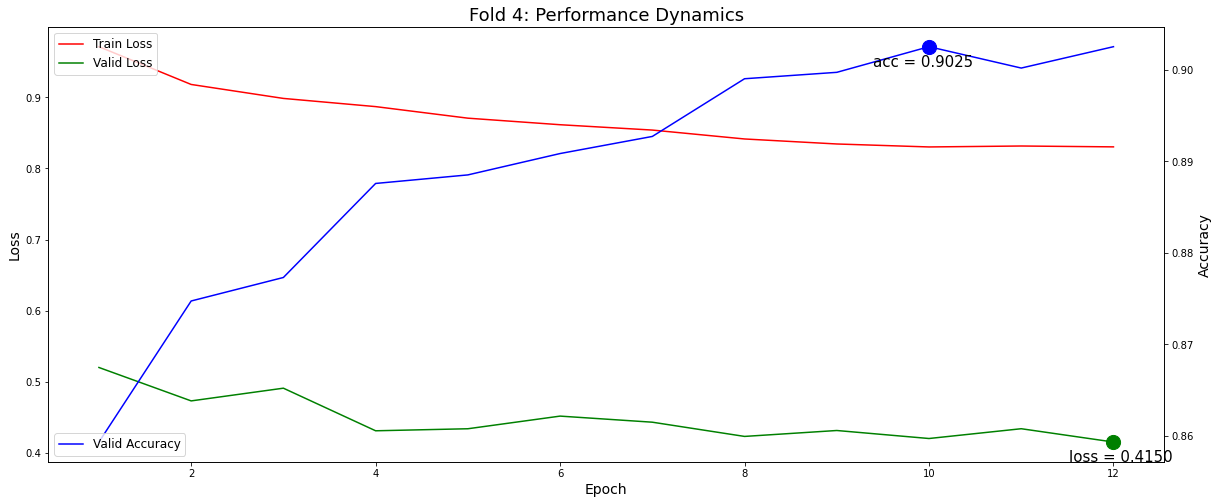


Finished in 840.80 minutes


In [31]:
####### CROSS-VALIDATION LOOP

##### INITIALIZATION

# timer
cv_start = time.time()

# clear memory
import gc
gc.collect()

# placeholders
oof = None
perf = pd.DataFrame(columns = ['fold', 'epoch', 'trn_loss', 'val_loss', 'val_acc'])
if not CFG['training']:
    perf = pd.read_csv(CFG['out_path'] + 'tab_performance.csv')

# amp settings
amp_autocast = suppress
if CFG['use_amp']:
    amp_autocast = torch.cuda.amp.autocast
    scaler       = torch.cuda.amp.GradScaler()       

# adjust epochs if needed
if not CFG['training']:
    CFG['num_epochs'] = 1
    CFG['fine_tune']   = False
if CFG['debug']:
    CFG['num_epochs'] = 2
    CFG['num_folds']  = 2
    CFG['fine_tune']   = 1
    
    
##### CROSS-VALIDAION

for fold in range(CFG['num_folds']):
    
    ### PERFORM MODELING
    
    # feedback
    print('-' * 55)
    print('FOLD {:d}/{:d}'.format(fold + 1, CFG['num_folds']))    
    print('-' * 55) 
    
    # prepare data
    trn_loader, val_loader, df_trn, df_val = get_data(df, fold, CFG)   

    # training and inference
    if CFG['device'] != 'TPU':
        trn_losses, val_losses, val_metrics, val_preds_best = run_fold(fold, trn_loader, val_loader, df_trn, df_val, CFG, device)
    else:
        def _mp_fn(rank, CFG):
            torch.set_default_tensor_type('torch.FloatTensor')
            device = xm.xla_device()
            trn_losses, val_losses, val_metrics, val_preds_best = run_fold(fold, trn_loader, val_loader, df_trn, df_val, CFG, device)
            if rank == 0:
                np.save('trn_losses.npy',     np.array(trn_losses))
                np.save('val_losses.npy',     np.array(val_losses))
                np.save('val_metrics.npy',    np.array(val_metrics))
                np.save('val_preds_best.npy', val_preds_best)
        xmp.spawn(_mp_fn, args = (CFG, ), nprocs = CFG['num_workers'], start_method = 'fork')
        trn_losses          = np.load('trn_losses.npy')
        val_losses          = np.load('val_losses.npy')
        val_metrics         = np.load('val_metrics.npy')
        val_preds_best      = np.load('val_preds_best.npy')


    ### SAVE RESULTS
    
    # performance table
    if CFG['training']:
        perf = pd.concat([perf, 
                          pd.DataFrame({'fold':     [fold] * (CFG['num_epochs'] + CFG['fine_tune']), 
                                        'epoch':    list(range(CFG['num_epochs'] + CFG['fine_tune'])),
                                        'trn_loss': trn_losses,
                                        'val_loss': val_losses,
                                        'val_acc':  val_metrics})],
                        axis = 0)
        perf.to_csv(CFG['out_path'] + 'tab_performance.csv', index = False)
            
    # export OOF predictions
    val_preds_df = pd.DataFrame(val_preds_best, columns = ['c' + str(class_idx) for class_idx in range(CFG['num_classes'])])
    val_preds_df = pd.concat([df_val, val_preds_df], axis = 1)
    oof = pd.concat([oof, val_preds_df], axis = 0).reset_index(drop = True)
    oof.to_csv(CFG['out_path'] + 'oof.csv', index = False)


    ### DISPLAY FEEDBACK

    # feedback
    print('-' * 55)
    print('Best: acc = {:.4f} (epoch {}), loss = {:.4f} (epoch {})'.format(
        np.max(val_metrics), np.argmax(val_metrics) + 1, np.min(val_losses), np.argmin(val_losses) + 1))
    print('-' * 55)

    # plot loss dynamics
    if CFG['training']:
        plot_results(trn_losses, val_losses, val_metrics, fold, CFG)


##### FEEDBACK

print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# EVALUATION

In [32]:
####### CHECK OOF PERFORMANCE

# compute accuracy
oof['pred'] = np.argmax(oof[['c' + str(class_idx) for class_idx in range(CFG['num_classes'])]].values, axis = 1)
oof_acc     = (oof['pred'] == oof['label']).sum() / len(oof)
oof_loss    = perf.groupby('fold')['val_loss'].agg('min').mean()

# print results
print('- OOF acc  = {:.4f}'.format(oof_acc))
print('- OOF loss = {:.4f}'.format(oof_loss))

# save results
res = pd.DataFrame({'fold':     ['oof',], 
                    'epoch':    ['best'],
                    'trn_loss': [np.nan],
                    'val_loss': [oof_loss],
                    'val_acc':  [oof_acc]})
perf = pd.concat([perf, res], axis = 0)
perf.to_csv(CFG['out_path'] + 'tab_performance.csv', index = False)

- OOF acc  = 0.8961
- OOF loss = 0.4208


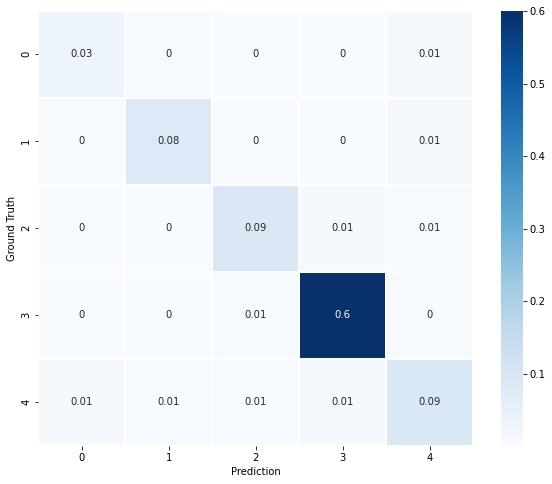

In [33]:
####### CONFUSION MATRIX

# construct confusion matrx
cm    = confusion_matrix(y_true = oof['label'], y_pred = oof['pred'], normalize = 'all')
annot = np.around(cm, 2)

# plot matrix
fig, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(cm, cmap = 'Blues', annot = annot, lw = 0.5)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth')
ax.set_aspect('equal')
    
# export plot
plt.savefig(CFG['out_path'] + 'fig_confusion.png')

In [34]:
####### PREDICTIONS WITH GRADCAM SETTINGS

# images per classs
sample = 4

# get augmentations
_, sample_augs = get_augs(CFG, image_size = 512)

# get model with weights
model, _, _ = get_model(CFG, device)
model.load_state_dict(torch.load(CFG['out_path'] + 'weights_fold{}.pth'.format(fold), map_location = device))

# feature and target modules
if 'efficient' in CFG['backbone']:
    feature_block = model.blocks
    target_layers = ['6']
else:
    feature_block = model.layer4
    target_layers = ['2']

# gradcam
grad_cam = GradCam(model              = model, 
                   feature_module     = feature_block,
                   target_layer_names = target_layers, 
                   use_cuda           = True)

# prepare dataframes
oof['correct']    = oof['pred'] == oof['label']
oof['confidence'] = np.max(oof[['c' + str(class_idx) for class_idx in range(CFG['num_classes'])]].values, axis = 1)
oof               = oof.sort_values(['label', 'confidence'], ascending = True)
rights = oof.loc[oof['correct'] == True].groupby('label').tail(sample).reset_index(drop  = True)
wrongs = oof.loc[oof['correct'] == False].groupby('label').tail(sample).reset_index(drop = True)

# datasets
right_dataset = LeafData(data      = rights, 
                         directory = CFG['data_path'] + 'train_images/',
                         transform = sample_augs,
                         labeled   = True)
wrong_dataset = LeafData(data      = wrongs,  
                         directory = CFG['data_path'] + 'train_images/',
                         transform = sample_augs,
                         labeled   = True)
# data loaders
right_loader = DataLoader(dataset     = right_dataset, 
                          batch_size  = sample * CFG['num_classes'], 
                          shuffle       = False, 
                          num_workers = 0,
                          pin_memory  = True)
wrong_loader = DataLoader(dataset     = wrong_dataset, 
                          batch_size  = sample * CFG['num_classes'],
                          shuffle       = False, 
                          num_workers = 0,
                          pin_memory  = True)

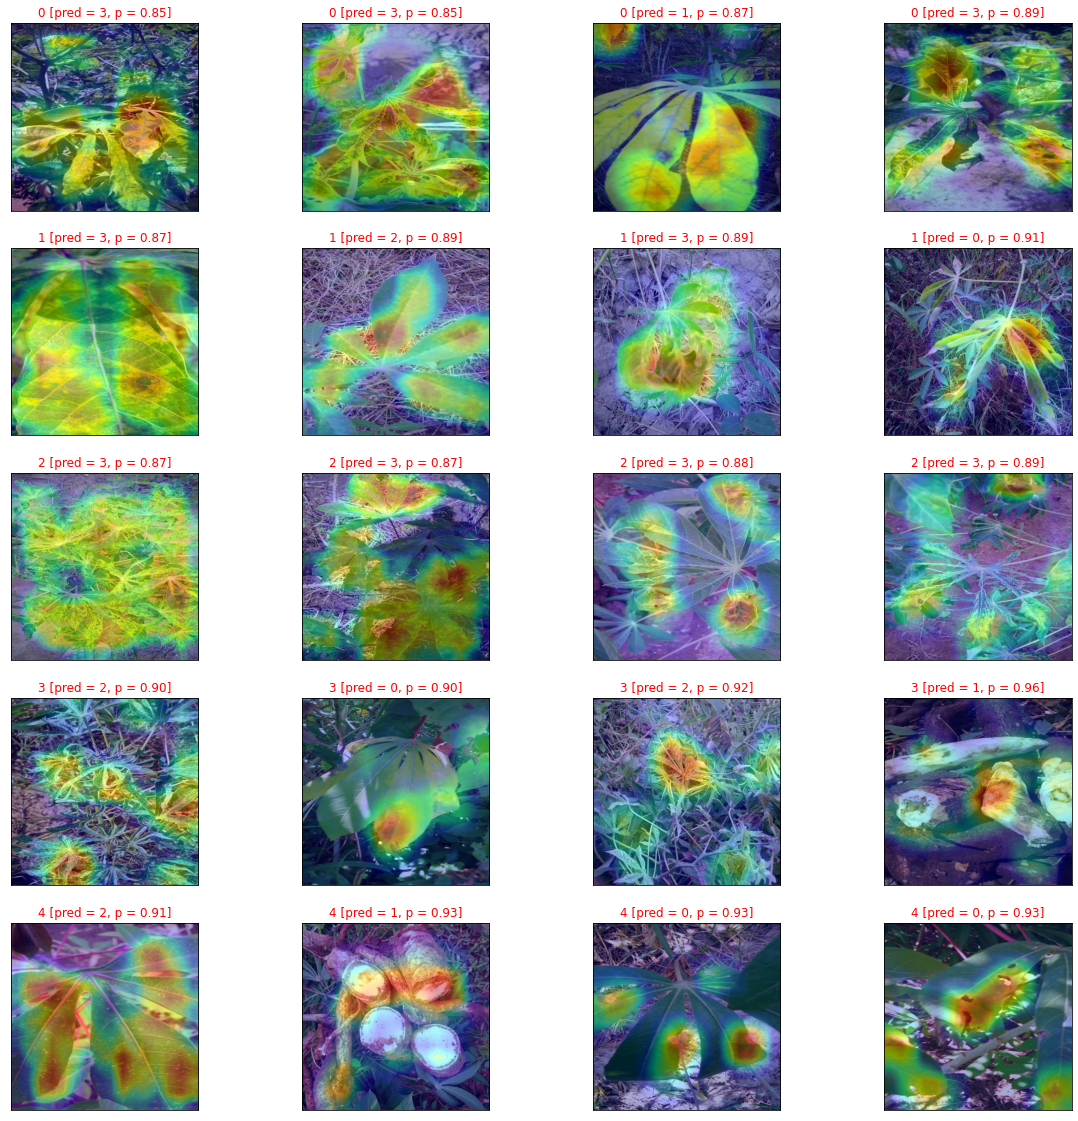

In [35]:
####### EXAMINE WRONG PREDICTIONS 

# display and save image grid
fig = plt.figure(figsize = (20, 20))
for batch_idx, (inputs, labels) in enumerate(wrong_loader):
    for i in range(inputs.shape[0]):

        # compute gradcam
        grayscale_cam = grad_cam(inputs[i].unsqueeze(0), None)
        cam = show_cam_on_image(inputs[i].numpy().transpose(1, 2, 0), grayscale_cam)

        # plot results
        ax = fig.add_subplot(CFG['num_classes'], sample, i + 1, xticks = [], yticks = [])     
        plt.imshow(cam)
        ax.set_title('{} [pred = {}, p = {:.2f}]'.format(
            labels[i].numpy(), wrongs.iloc[i]['pred'], wrongs.iloc[i]['confidence']), color = 'red')
        
# export
plt.savefig(CFG['out_path'] + 'fig_preds_wrong.png')

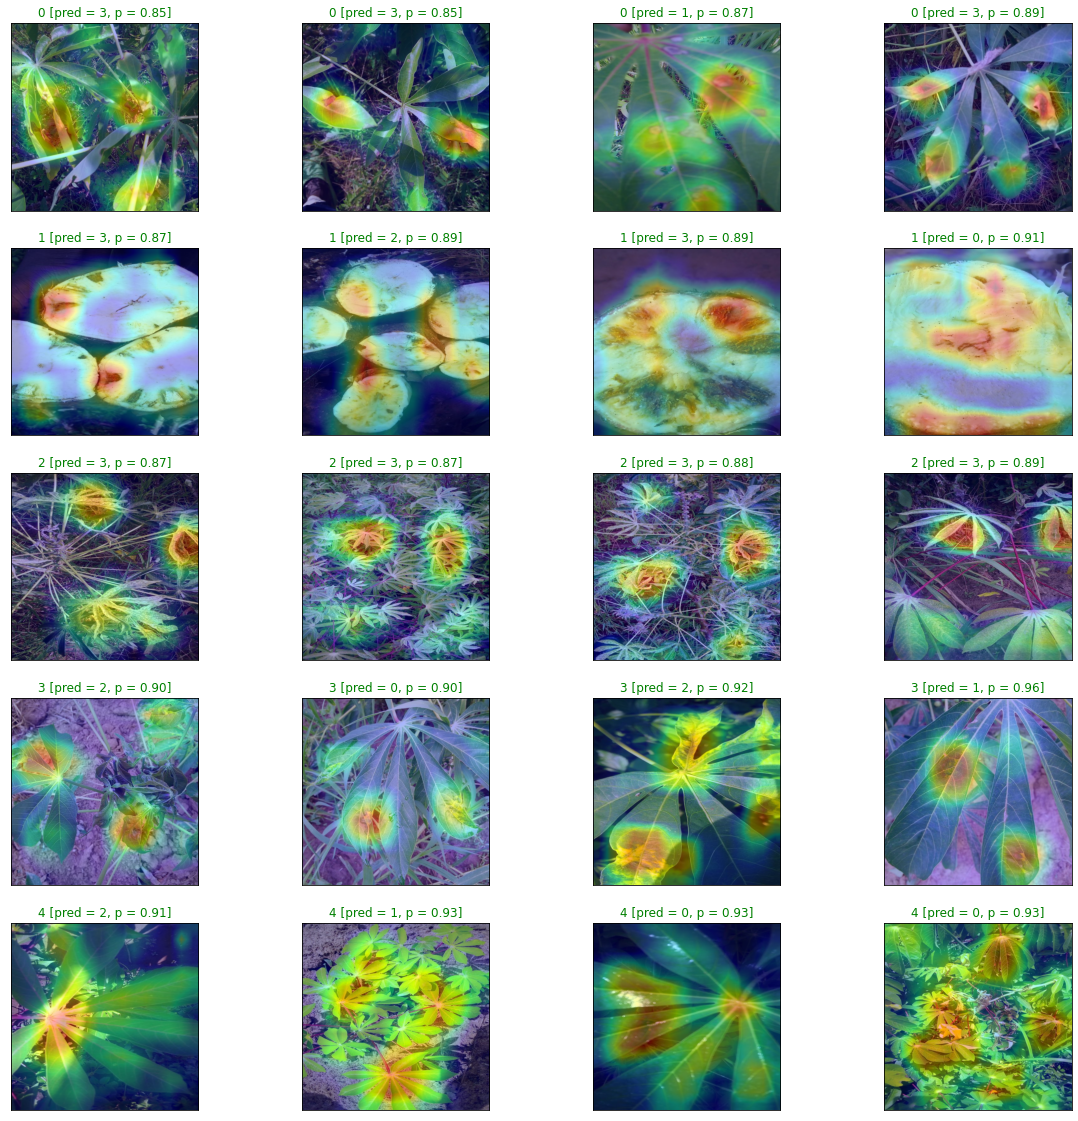

In [36]:
####### EXAMINE RIGHT PREDICTIONS 

# display and save image grid
fig = plt.figure(figsize = (20, 20))
for batch_idx, (inputs, labels) in enumerate(right_loader):
    for i in range(inputs.shape[0]):

        # compute gradcam
        grayscale_cam = grad_cam(inputs[i].unsqueeze(0), None)
        cam = show_cam_on_image(inputs[i].numpy().transpose(1, 2, 0), grayscale_cam)

        # plot results
        ax = fig.add_subplot(CFG['num_classes'], sample, i + 1, xticks = [], yticks = [])     
        plt.imshow(cam)
        ax.set_title('{} [pred = {}, p = {:.2f}]'.format(
            labels[i].numpy(), wrongs.iloc[i]['pred'], wrongs.iloc[i]['confidence']), color = 'green')
        
# export
plt.savefig(CFG['out_path'] + 'fig_preds_right.png')

In [37]:
####### EXPORT CONFIGURATION

# store performance values
CFG['time_min'] = (time.time() - cv_start) / 60
CFG['oof_acc']  = oof_acc
CFG['oof_loss'] = oof_loss

# save DF
params = pd.DataFrame.from_dict(CFG, orient = 'index', columns = ['value'])
params.to_csv(CFG['out_path'] + 'tab_configuration.csv', index = True)

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

In [38]:
####### SENDING TO NEPTUNE

if CFG['tracking']:

    # metrics
    neptune.send_metric('oof_acc',  oof_acc)
    neptune.send_metric('oof_loss', oof_loss)
        
    # images
    neptune.send_image('confusion',   CFG['out_path'] + 'fig_confusion.png')
    neptune.send_image('predictions', CFG['out_path'] + 'fig_preds_right.png')
    neptune.send_image('predictions', CFG['out_path'] + 'fig_preds_wrong.png')

    # model weights
    for fold in range(CFG['num_folds']):
        neptune.send_artifact(CFG['out_path'] + 'weights_fold{}.pth'.format(fold))

    # OOF predictions
    neptune.send_artifact(CFG['out_path'] + 'oof.csv')

    # CFG and performance
    neptune.send_artifact(CFG['out_path'] + 'tab_performance.csv') 
    neptune.send_artifact(CFG['out_path'] + 'tab_configuration.csv') 

    # stop experiment
    neptune.stop()